<a href="https://colab.research.google.com/github/xDaryamo/NFR-Security-Extraction-Classification/blob/master/NFR_Classification_Categorization_Tfidf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0) Dipendenze e utils


##0.1 Dipendenze

In [10]:
!python -m spacy download en_core_web_trf --quiet
!pip install spacy-transformers --quiet

2022-11-29 21:43:38.139249: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
     |████████████████████████████████| 460.3 MB 32 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')


In [11]:
!pip install scikit-plot --quiet
!pip install scikit-multilearn --quiet

In [12]:
import pandas as pd
import spacy
from spacy import displacy
from tabulate import tabulate
from string import punctuation
import re
import spacy_transformers
import numpy as np
from numpy import mean
import ast
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score, plot_confusion_matrix, balanced_accuracy_score, hamming_loss, f1_score, multilabel_confusion_matrix,ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.model_selection import RepeatedKFold, KFold,StratifiedKFold,RandomizedSearchCV
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict, GridSearchCV, train_test_split
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn.preprocessing import MultiLabelBinarizer
import skmultilearn
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain, LabelPowerset
import warnings



In [13]:
nlp = spacy.load("en_core_web_trf")

##0.2) Funzioni utili

In [14]:
all_entities = list(nlp.get_pipe("ner").labels)
all_pos = ['ADJ','ADP','ADV','AUX','CONJ','CCONJ','DET','INTJ','NOUN','NUM','PART','PRON','PROPN','PUNCT','SCONJ','SYM','VERB','X','SPACE']
all_dep = list(nlp.get_pipe("parser").labels)

In [15]:
def str_to_list(ent, dep, pos):
  if not isinstance(ent, list):
    ent = ast.literal_eval(ent)
    ent = [n.strip() for n in ent]
  if not isinstance(dep, list):
    dep = ast.literal_eval(dep)
    dep = [n.strip() for n in dep]
  if not isinstance(pos, list):
    pos = ast.literal_eval(pos)
    pos = [n.strip() for n in pos]

  return ent, dep, pos

In [16]:
def conc_3_lists(a,b,c):
  temp = np.concatenate((a, b), axis=0)
  result = np.concatenate((temp, c), axis=0)
  return " ".join(result.tolist())


In [17]:
def extract_features(ent, dep, pos):
  ent, dep, pos = str_to_list(ent,dep,pos)
  return conc_3_lists(ent, dep, pos)

#1) Classificatore Binario

## 1.1) Ottenimento del Dataset

In [18]:
root="https://raw.githubusercontent.com/xDaryamo/NFR-Security-Extraction-Classification/master/"


#df è la variabile che contiene il dataset
df=pd.read_excel(root + "dataset.xlsx")

df=df[["Sentence","Entities", "Dependencies", "Parts of Speech", "Categories", "Security Words", "Security"]]
df.head(5)


,Sentence,Entities,Dependencies,Parts of Speech,Categories,Security Words,Security
0,The vision of healthier Canadians through inno...,"['The', 'vision', 'of', 'healthier', 'NORP', '...","['det', 'nsubjpass', 'prep', 'amod', 'pobj', '...","['DET', 'NOUN', 'ADP', 'ADJ', 'PROPN', 'ADP', ...","['CONFIDENTIALITY', 'AVAILABILITY', 'INTEGRITY']",['access'],1
1,"Once completed, the electronic health record (...","['Once', 'completed', 'the', 'electronic', 'he...","['advmod', 'advcl', 'det', 'amod', 'compound',...","['ADV', 'VERB', 'DET', 'ADJ', 'NOUN', 'NOUN', ...",none,none,0
2,Canada Health Infoway's (Infoway's) Nursing Re...,"['ORG', 'ORG', 'ORG', 'ORG', 'ORG', ""'s"", 'ORG...","['compound', 'compound', 'poss', 'case', 'poss...","['PROPN', 'PROPN', 'PROPN', 'PART', 'PROPN', '...",none,none,0
3,Timely access to information will help inform ...,"['Timely', 'access', 'to', 'information', 'wil...","['amod', 'nsubj', 'prep', 'pobj', 'aux', 'ROOT...","['ADJ', 'NOUN', 'ADP', 'NOUN', 'AUX', 'VERB', ...",['AVAILABILITY'],['access'],1
4,"As part of the NRG, a pan-Canadian working gro...","['As', 'part', 'of', 'the', 'ORG', 'a', 'NORP'...","['prep', 'pobj', 'prep', 'det', 'pobj', 'det',...","['ADP', 'NOUN', 'ADP', 'DET', 'PROPN', 'DET', ...",none,none,0


##1.2) Codifica delle features

In [19]:
sec_df=pd.DataFrame(columns=["Entities", "Dependencies", "Parts of Speech", "Text", "Security Words", "Security"])

for i in range(0, len(df)):
  ent, dep, pos = df.iloc[i]["Entities"], df.iloc[i]["Dependencies"], df.iloc[i]["Parts of Speech"]
  sec_df.loc[i, "Entities"] = ent
  sec_df.loc[i, "Dependencies"] = dep
  sec_df.loc[i, "Parts of Speech"] = pos
  sec_df.loc[i, "Text"] = extract_features(ent,dep,pos)
  sec_df.loc[i, "Security Words"] = df.iloc[i]["Security Words"]
  sec_df.loc[i, "Security"] = df.iloc[i]["Security"]

sec_df.head()

,Entities,Dependencies,Parts of Speech,Text,Security Words,Security
0,"['The', 'vision', 'of', 'healthier', 'NORP', '...","['det', 'nsubjpass', 'prep', 'amod', 'pobj', '...","['DET', 'NOUN', 'ADP', 'ADJ', 'PROPN', 'ADP', ...",The vision of healthier NORP through innovativ...,['access'],1
1,"['Once', 'completed', 'the', 'electronic', 'he...","['advmod', 'advcl', 'det', 'amod', 'compound',...","['ADV', 'VERB', 'DET', 'ADJ', 'NOUN', 'NOUN', ...",Once completed the electronic health record EH...,none,0
2,"['ORG', 'ORG', 'ORG', 'ORG', 'ORG', ""'s"", 'ORG...","['compound', 'compound', 'poss', 'case', 'poss...","['PROPN', 'PROPN', 'PROPN', 'PART', 'PROPN', '...",ORG ORG ORG ORG ORG 's ORG ORG ORG ORG recogni...,none,0
3,"['Timely', 'access', 'to', 'information', 'wil...","['amod', 'nsubj', 'prep', 'pobj', 'aux', 'ROOT...","['ADJ', 'NOUN', 'ADP', 'NOUN', 'AUX', 'VERB', ...",Timely access to information will help inform ...,['access'],1
4,"['As', 'part', 'of', 'the', 'ORG', 'a', 'NORP'...","['prep', 'pobj', 'prep', 'det', 'pobj', 'det',...","['ADP', 'NOUN', 'ADP', 'DET', 'PROPN', 'DET', ...",As part of the ORG a NORP NORP working group w...,none,0


In [20]:
vocabulary = [*all_entities, *all_dep, *all_pos]

for sentence in sec_df["Text"]:
  for word in sentence.split(" "):
    if word not in vocabulary:
      vocabulary.append(word)

len(vocabulary)

7048

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfVectorizer(analyzer='word', max_features=10000, vocabulary=vocabulary, lowercase=False)

X = tfidf.fit_transform(sec_df['Text']).toarray()
y = sec_df['Security']
y = y.astype('int')
print(X.shape)
print(y.shape)


(5980, 7048)
(5980,)


##1.3) Tuning degli iperparametri


In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
warnings.filterwarnings("ignore")

###1.3.1) Tuning RandomForest

In [ ]:
rf = RandomForestClassifier() 

n_estimators = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points


rf_grid = {
            'n_estimators': n_estimators,
            'max_features': max_features,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf,
            'bootstrap': bootstrap
          }

rf_model = RandomizedSearchCV(estimator = rf, param_distributions=rf_grid, n_iter=60, cv=cv, verbose=2,random_state=35, n_jobs = -1)
rf_model.fit(X, y)

rf_best = rf_model.best_params_
print('Config: %s' % rf_best)


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Config: {'n_estimators': 20, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 70, 'bootstrap': False}


###1.3.2) Tuning LogisticRegression

In [ ]:
lr = LogisticRegression()

lr_grid = [
            {
              'solver' : ['saga'],
              'penalty' : ['elasticnet', 'l1', 'l2', 'none'],
              'max_iter' : [100, 250, 500],
              'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
            {
              'solver' : ['newton-cg', 'lbfgs'],
              'penalty' : ['l2','none'],
              'max_iter' :[100, 250, 500],
              'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
          ]

lr_model = RandomizedSearchCV(estimator = lr, param_distributions=lr_grid, n_iter=60, cv=cv, verbose=2,random_state=35, n_jobs = -1)
lr_model.fit(X, y)

lr_best = lr_model.best_params_
print('Config: %s' % lr_best)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Config: {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 500, 'C': 10}


###1.3.3) Tuning SVM

In [ ]:
svm = LinearSVC()

svm_grid =  [
              {
                'C': [0.1,1, 10, 100, 1000], 
                'penalty' : ['l2'],
                'loss' : ['hinge'],
                'dual' : [True, False],
                'fit_intercept' : [True, False]


              },
              {
                'C': [0.1,1, 10, 100, 1000], 
                'penalty' : ['l1', 'l2'],
                'loss' : ['squared_hinge'],
                'dual' : [True, False],
                'fit_intercept' : [True, False]

              }

            ]

svm_model = RandomizedSearchCV(estimator = svm, param_distributions=svm_grid, n_iter=60, cv=cv, verbose=2,random_state=35, n_jobs = -1)
svm_model.fit(X, y)

svm_best = svm_model.best_params_
print('Config: %s' % svm_best)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Config: {'penalty': 'l2', 'loss': 'hinge', 'fit_intercept': True, 'dual': True, 'C': 1}


###1.3.4) Tuning GaussianNB

In [ ]:
gNB = GaussianNB()

nb_grid = {
            'var_smoothing': np.logspace(0,-9, num=100)
          }       

nb_model = RandomizedSearchCV(estimator = gNB, param_distributions=nb_grid, n_iter=60, cv=cv, verbose=2,random_state=35, n_jobs = -1)
nb_model.fit(X, y)

nb_best = nb_model.best_params_
print('Config: %s' % nb_best)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Config: {'var_smoothing': 0.01}


###1.3.5) Tuning KNN

In [ ]:
knn = KNeighborsClassifier(algorithm='auto')


knn_grid =  {
              'n_neighbors': (1,10, 1),
              'leaf_size': (20,40,1),
              'p': (1,2),
              'weights': ('uniform', 'distance'),
              'metric': ('minkowski', 'chebyshev'),
            }       

knn_model = RandomizedSearchCV(estimator = knn, param_distributions=knn_grid, n_iter=60, cv=cv, verbose=2,random_state=35, n_jobs = -1)
knn_model.fit(X, y)

knn_best = knn_model.best_params_
print('Config: %s' % knn_best)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Config: {'weights': 'distance', 'p': 2, 'n_neighbors': 1, 'metric': 'minkowski', 'leaf_size': 1}


###1.3.6) Tuning DecisionTree

In [ ]:
dt = DecisionTreeClassifier()


dt_grid = {
            'max_features': ['auto', 'sqrt', 'log2'],
            'ccp_alpha': [0.1, .01, .001],
            'max_depth' : [5, 6, 7, 8, 9],
            'criterion' :['gini', 'entropy']
          }    

dt_model = RandomizedSearchCV(estimator = dt, param_distributions=dt_grid, n_iter=60, cv=cv, verbose=2,random_state=35, n_jobs = -1)
dt_model.fit(X, y)

dt_best = dt_model.best_params_
print('Config: %s' % dt_best)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Config: {'max_features': 'sqrt', 'max_depth': 7, 'criterion': 'entropy', 'ccp_alpha': 0.001}


##1.4) Validazione modelli con Cross-Fold Validation

In [22]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

X = tfidf.fit_transform(sec_df['Text']).toarray()
y = sec_df['Security']
y = y.astype('int')

print(X.shape)
print(y.shape)

(5980, 7048)
(5980,)


Creazione dataframe risultati

In [23]:
indexes = ['Accuracy-mean', 'F1-mean', 'Precision-mean', 'Recall-mean', 
           'Accuracy-fold1','F1-fold1','Precision-fold1','Recall-fold1',
           'Accuracy-fold2','F1-fold2','Precision-fold2','Recall-fold2',
           'Accuracy-fold3','F1-fold3','Precision-fold3','Recall-fold3',
           'Accuracy-fold4','F1-fold4','Precision-fold4','Recall-fold4',
           'Accuracy-fold5','F1-fold5','Precision-fold5','Recall-fold5'
]
results = pd.DataFrame(index=indexes,
                      columns=['Logistic Regression','Random Forest', 'GaussianNB', 'LinearSVM', 'kNN', 'Decision Tree'])

results.head()

,Logistic Regression,Random Forest,GaussianNB,LinearSVM,kNN,Decision Tree
Accuracy-mean,NaN,NaN,NaN,NaN,NaN,NaN
F1-mean,NaN,NaN,NaN,NaN,NaN,NaN
Precision-mean,NaN,NaN,NaN,NaN,NaN,NaN
Recall-mean,NaN,NaN,NaN,NaN,NaN,NaN
Accuracy-fold1,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
df_pred1 = pd.DataFrame(columns=['Real Label', 'LogisticRegression', 'RandomForestClassifier','GaussianNB','LinearSVC', 'KNeighborsClassifier', 'DecisionTreeClassifier'])
for i in range(0, len(sec_df)):
  df_pred1.loc[i, 'Real Label'] = sec_df.iloc[i]["Security"]


df_pred2 = df_pred1.copy(deep=True)
df_pred3 = df_pred1.copy(deep=True)
df_pred4 = df_pred1.copy(deep=True)
df_pred5 = df_pred1.copy(deep=True)
df_pred1.head()

,Real Label,LogisticRegression,RandomForestClassifier,GaussianNB,LinearSVC,KNeighborsClassifier,DecisionTreeClassifier
0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,0,NaN,NaN,NaN,NaN,NaN,NaN
2,0,NaN,NaN,NaN,NaN,NaN,NaN
3,1,NaN,NaN,NaN,NaN,NaN,NaN
4,0,NaN,NaN,NaN,NaN,NaN,NaN


###1.4.1) Logistic regression

fit_time:  4.681560325622558
Accuracy:  0.8481605351170568
F1:  0.889395335162561
Precision:  0.87419107001172
Recall:  0.9052545807312565


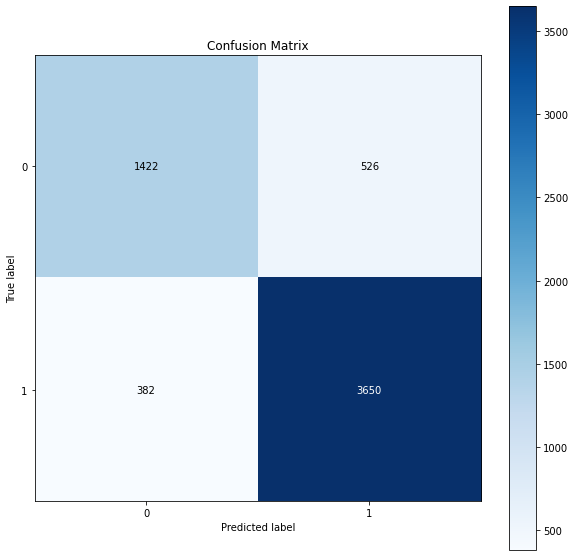

In [25]:
lr = LogisticRegression(solver='newton-cg', penalty='l2', max_iter= 500, C=10)

scoring = {'accuracy': 'accuracy',
           'f1': 'f1',
           'precision': 'precision',
           'recall': 'recall'}
lr_scores = cross_validate(lr, X, y, scoring=scoring, cv=cv)
print("fit_time: ",np.mean(lr_scores['fit_time']))
print("Accuracy: ",np.mean(lr_scores['test_accuracy']))
print("F1: ",np.mean(lr_scores['test_f1']))
print("Precision: ",np.mean(lr_scores['test_precision']))
print("Recall: ",np.mean(lr_scores['test_recall']))

results.loc['Accuracy-mean']['Logistic Regression'] = np.mean(lr_scores['test_accuracy'])
results.loc['F1-mean']['Logistic Regression'] = np.mean(lr_scores['test_f1'])
results.loc['Precision-mean']['Logistic Regression'] = np.mean(lr_scores['test_precision'])
results.loc['Recall-mean']['Logistic Regression'] = np.mean(lr_scores['test_recall'])

for i in range (0,5):
  acc = "Accuracy-fold"
  f1 = "F1-fold"
  prec = "Precision-fold"
  rec = "Recall-fold"
  results.loc[acc+str(i+1)]['Logistic Regression'] = lr_scores['test_accuracy'][i]
  results.loc[f1+str(i+1)]['Logistic Regression'] = lr_scores['test_f1'][i]
  results.loc[prec+str(i+1)]['Logistic Regression'] = lr_scores['test_precision'][i]
  results.loc[rec+str(i+1)]['Logistic Regression'] = lr_scores['test_recall'][i]

predictions = cross_val_predict(lr, X, y,cv=cv)

fold_pred = [predictions[j] for i, j in cv.split(X,y)]


for i in range(0, len(list(fold_pred[0]))):
  df_pred1.loc[i, "LogisticRegression"] = list(fold_pred[0])[i]
  df_pred2.loc[i, "LogisticRegression"] = list(fold_pred[1])[i]
  df_pred3.loc[i, "LogisticRegression"] = list(fold_pred[2])[i]
  df_pred4.loc[i, "LogisticRegression"] = list(fold_pred[3])[i]
  df_pred5.loc[i, "LogisticRegression"] = list(fold_pred[4])[i]
fig, ax = plt.subplots(figsize=(10, 10))

ax2 = skplt.metrics.plot_confusion_matrix(y, predictions,cmap=plt.cm.Blues, ax=ax)
plt.show()


###1.4.2) RandomForest

fit_time:  2.1418824195861816
Accuracy:  0.8053511705685619
F1:  0.8647841900364821
Precision:  0.8133268399771125
Recall:  0.9233591926720599


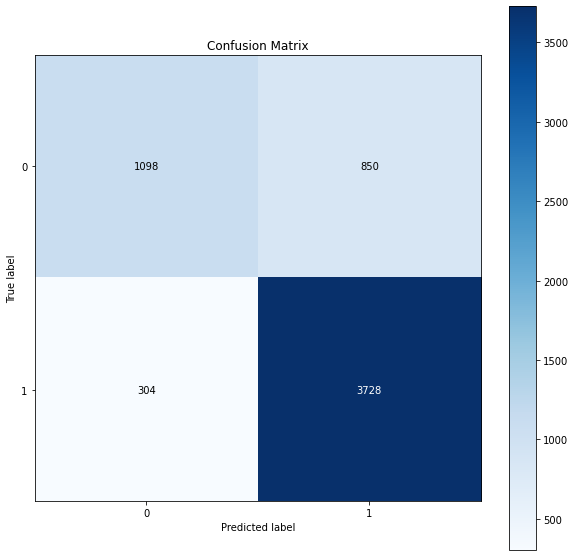

In [26]:
rf = RandomForestClassifier(n_estimators=20, min_samples_split=10, min_samples_leaf=1, max_features='sqrt', max_depth=70, bootstrap=False)

scoring = {'accuracy': 'accuracy',
           'f1': 'f1',
           'precision': 'precision',
           'recall': 'recall'}

rf_scores = cross_validate(rf, X, y, scoring=scoring, cv=cv)
print("fit_time: ",np.mean(rf_scores['fit_time']))
print("Accuracy: ",np.mean(rf_scores['test_accuracy']))
print("F1: ",np.mean(rf_scores['test_f1']))
print("Precision: ",np.mean(rf_scores['test_precision']))
print("Recall: ",np.mean(rf_scores['test_recall']))


results.loc['Accuracy-mean']['Random Forest'] = np.mean(rf_scores['test_accuracy'])
results.loc['F1-mean']['Random Forest'] = np.mean(rf_scores['test_f1'])
results.loc['Precision-mean']['Random Forest'] = np.mean(rf_scores['test_precision'])
results.loc['Recall-mean']['Random Forest'] = np.mean(rf_scores['test_recall'])

for i in range (0,5):
  acc = "Accuracy-fold"
  f1 = "F1-fold"
  prec = "Precision-fold"
  rec = "Recall-fold"
  results.loc[acc+str(i+1)]['Random Forest'] = rf_scores['test_accuracy'][i]
  results.loc[f1+str(i+1)]['Random Forest'] = rf_scores['test_f1'][i]
  results.loc[prec+str(i+1)]['Random Forest'] = rf_scores['test_precision'][i]
  results.loc[rec+str(i+1)]['Random Forest'] = rf_scores['test_recall'][i]

predictions = cross_val_predict(rf, X, y,cv=cv)

fold_pred = [predictions[j] for i, j in cv.split(X,y)]


for i in range(0, len(list(fold_pred[0]))):
  df_pred1.loc[i, "RandomForestClassifier"] = list(fold_pred[0])[i]
  df_pred2.loc[i, "RandomForestClassifier"] = list(fold_pred[1])[i]
  df_pred3.loc[i, "RandomForestClassifier"] = list(fold_pred[2])[i]
  df_pred4.loc[i, "RandomForestClassifier"] = list(fold_pred[3])[i]
  df_pred5.loc[i, "RandomForestClassifier"] = list(fold_pred[4])[i]


fig, ax = plt.subplots(figsize=(10, 10))

ax2 = skplt.metrics.plot_confusion_matrix(y, predictions,cmap=plt.cm.Blues, ax=ax)
plt.show()


###1.4.3) Gaussian Naive Bayes

fit_time:  0.29227428436279296
Accuracy:  0.8170568561872911
F1:  0.8170568561872911
Precision:  0.8297864408636857
Recall:  0.9169109620842443


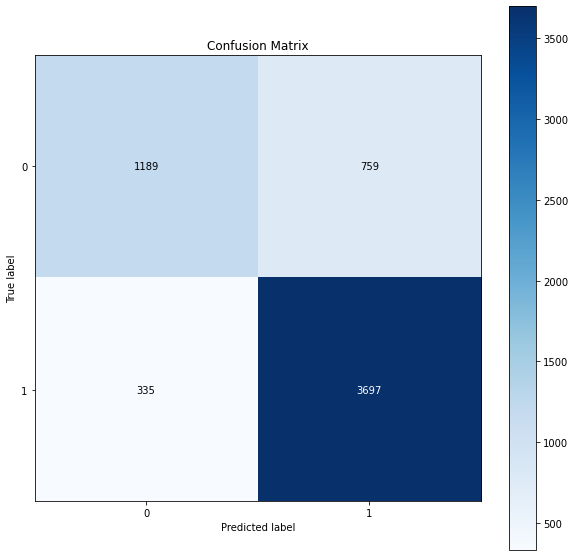

In [28]:
gNB = GaussianNB(var_smoothing=0.01)

scoring = {'accuracy': 'accuracy',
           'f1': 'f1_micro',
           'precision': 'precision',
           'recall': 'recall'}
gb_scores = cross_validate(gNB, X, y, scoring=scoring, cv=cv)
print("fit_time: ",np.mean(gb_scores['fit_time']))
print("Accuracy: ",np.mean(gb_scores['test_accuracy']))
print("F1: ",np.mean(gb_scores['test_f1']))
print("Precision: ",np.mean(gb_scores['test_precision']))
print("Recall: ",np.mean(gb_scores['test_recall']))


results.loc['Accuracy-mean']['GaussianNB'] = np.mean(gb_scores['test_accuracy'])
results.loc['F1-mean']['GaussianNB'] = np.mean(gb_scores['test_f1'])
results.loc['Precision-mean']['GaussianNB'] = np.mean(gb_scores['test_precision'])
results.loc['Recall-mean']['GaussianNB'] = np.mean(gb_scores['test_recall'])

for i in range (0,5):
  acc = "Accuracy-fold"
  f1 = "F1-fold"
  prec = "Precision-fold"
  rec = "Recall-fold"
  results.loc[acc+str(i+1)]['GaussianNB'] = gb_scores['test_accuracy'][i]
  results.loc[f1+str(i+1)]['GaussianNB'] = gb_scores['test_f1'][i]
  results.loc[prec+str(i+1)]['GaussianNB'] = gb_scores['test_precision'][i]
  results.loc[rec+str(i+1)]['GaussianNB'] = gb_scores['test_recall'][i]

predictions = cross_val_predict(gNB, X, y,cv=cv)

fold_pred = [predictions[j] for i, j in cv.split(X,y)]


for i in range(0, len(list(fold_pred[0]))):
  df_pred1.loc[i, "GaussianNB"] = list(fold_pred[0])[i]
  df_pred2.loc[i, "GaussianNB"] = list(fold_pred[1])[i]
  df_pred3.loc[i, "GaussianNB"] = list(fold_pred[2])[i]
  df_pred4.loc[i, "GaussianNB"] = list(fold_pred[3])[i]
  df_pred5.loc[i, "GaussianNB"] = list(fold_pred[4])[i]


fig, ax = plt.subplots(figsize=(10, 10))

ax2 = skplt.metrics.plot_confusion_matrix(y, predictions,cmap=plt.cm.Blues, ax=ax)
plt.show()


###1.4.4) Support Vector Machine

fit_time:  0.2627669334411621
Accuracy:  0.8508361204013377
F1:  0.8924975126640913
Precision:  0.8681920529481607
Recall:  0.9183976434486087


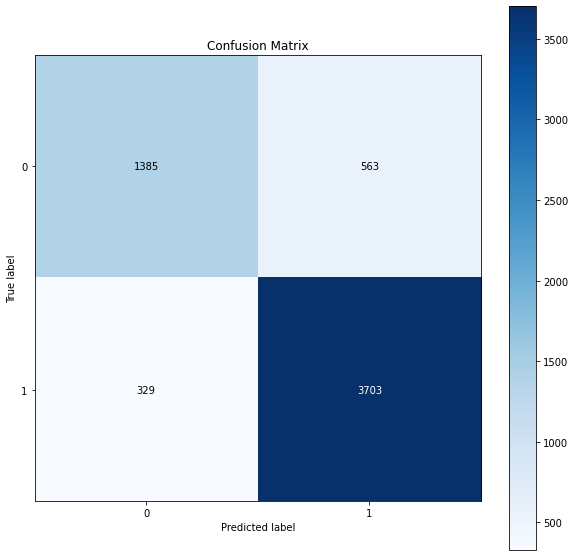

In [29]:
svm = LinearSVC(penalty='l2', loss='hinge', fit_intercept=True, dual=True, C=1)

scoring = {'accuracy': 'accuracy',
           'f1': 'f1',
           'precision': 'precision',
           'recall': 'recall'}
svm_scores = cross_validate(svm, X, y, scoring=scoring, cv=cv)
print("fit_time: ",np.mean(svm_scores['fit_time']))
print("Accuracy: ",np.mean(svm_scores['test_accuracy']))
print("F1: ",np.mean(svm_scores['test_f1']))
print("Precision: ",np.mean(svm_scores['test_precision']))
print("Recall: ",np.mean(svm_scores['test_recall']))


results.loc['Accuracy-mean']['LinearSVM'] = np.mean(svm_scores['test_accuracy'])
results.loc['F1-mean']['LinearSVM'] = np.mean(svm_scores['test_f1'])
results.loc['Precision-mean']['LinearSVM'] = np.mean(svm_scores['test_precision'])
results.loc['Recall-mean']['LinearSVM'] = np.mean(svm_scores['test_recall'])

for i in range (0,5):
  acc = "Accuracy-fold"
  f1 = "F1-fold"
  prec = "Precision-fold"
  rec = "Recall-fold"
  results.loc[acc+str(i+1)]['LinearSVM'] = svm_scores['test_accuracy'][i]
  results.loc[f1+str(i+1)]['LinearSVM'] = svm_scores['test_f1'][i]
  results.loc[prec+str(i+1)]['LinearSVM'] = svm_scores['test_precision'][i]
  results.loc[rec+str(i+1)]['LinearSVM'] = svm_scores['test_recall'][i]

predictions = cross_val_predict(svm, X, y,cv=cv)

fold_pred = [predictions[j] for i, j in cv.split(X,y)]


for i in range(0, len(list(fold_pred[0]))):
  df_pred1.loc[i, "LinearSVC"] = list(fold_pred[0])[i]
  df_pred2.loc[i, "LinearSVC"] = list(fold_pred[1])[i]
  df_pred3.loc[i, "LinearSVC"] = list(fold_pred[2])[i]
  df_pred4.loc[i, "LinearSVC"] = list(fold_pred[3])[i]
  df_pred5.loc[i, "LinearSVC"] = list(fold_pred[4])[i]
fig, ax = plt.subplots(figsize=(10, 10))

ax2 = skplt.metrics.plot_confusion_matrix(y, predictions,cmap=plt.cm.Blues, ax=ax)
plt.show()

###1.4.5) k-Nearest Neighbors

fit_time:  0.0623870849609375
Accuracy:  0.7944816053511705
F1:  0.8559449287206473
Precision:  0.811763288910965
Recall:  0.9052573480802284


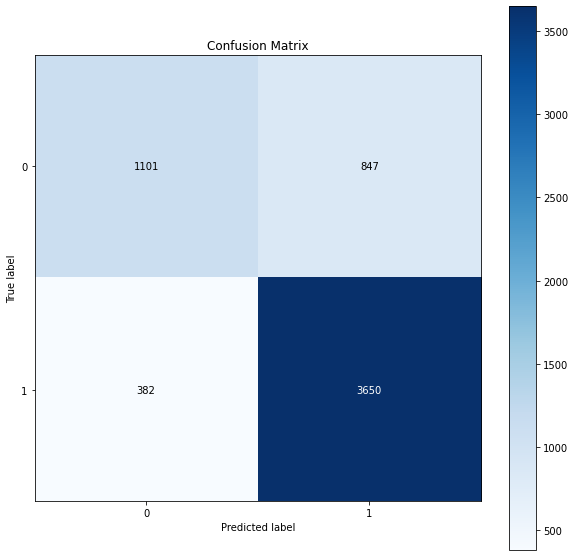

In [30]:
knn = KNeighborsClassifier(algorithm='auto',weights='distance',p=2,n_neighbors=1, metric='minkowski', leaf_size=1)

scoring = {'accuracy': 'accuracy',
           'f1': 'f1',
           'precision': 'precision',
           'recall': 'recall'}
knn_scores = cross_validate(knn, X, y, scoring=scoring, cv=cv)
print("fit_time: ",np.mean(knn_scores['fit_time']))
print("Accuracy: ",np.mean(knn_scores['test_accuracy']))
print("F1: ",np.mean(knn_scores['test_f1']))
print("Precision: ",np.mean(knn_scores['test_precision']))
print("Recall: ",np.mean(knn_scores['test_recall']))

results.loc['Accuracy-mean']['kNN'] = np.mean(knn_scores['test_accuracy'])
results.loc['F1-mean']['kNN'] = np.mean(knn_scores['test_f1'])
results.loc['Precision-mean']['kNN'] = np.mean(knn_scores['test_precision'])
results.loc['Recall-mean']['kNN'] = np.mean(knn_scores['test_recall'])

for i in range (0,5):
  acc = "Accuracy-fold"
  f1 = "F1-fold"
  prec = "Precision-fold"
  rec = "Recall-fold"
  results.loc[acc+str(i+1)]['kNN'] = knn_scores['test_accuracy'][i]
  results.loc[f1+str(i+1)]['kNN'] = knn_scores['test_f1'][i]
  results.loc[prec+str(i+1)]['kNN'] = knn_scores['test_precision'][i]
  results.loc[rec+str(i+1)]['kNN'] = knn_scores['test_recall'][i]

predictions = cross_val_predict(knn, X, y,cv=cv)

fold_pred = [predictions[j] for i, j in cv.split(X,y)]


for i in range(0, len(list(fold_pred[0]))):
  df_pred1.loc[i, "KNeighborsClassifier"] = list(fold_pred[0])[i]
  df_pred2.loc[i, "KNeighborsClassifier"] = list(fold_pred[1])[i]
  df_pred3.loc[i, "KNeighborsClassifier"] = list(fold_pred[2])[i]
  df_pred4.loc[i, "KNeighborsClassifier"] = list(fold_pred[3])[i]
  df_pred5.loc[i, "KNeighborsClassifier"] = list(fold_pred[4])[i]

fig, ax = plt.subplots(figsize=(10, 10))

ax2 = skplt.metrics.plot_confusion_matrix(y, predictions,cmap=plt.cm.Blues, ax=ax)
plt.show()


###1.4.6) Decision Tree

fit_time:  0.24526233673095704
Accuracy:  0.6839464882943144
F1_micro:  0.8031240591743487
Precision_micro:  0.6929421543719434
Recall_micro:  0.9571110106665929


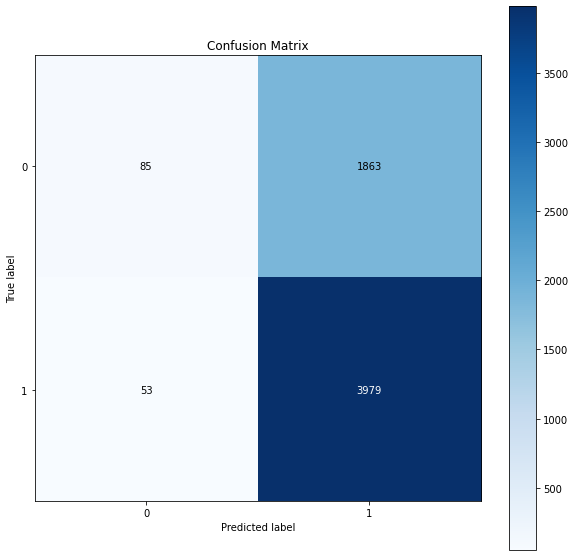

In [31]:
dt = DecisionTreeClassifier(max_features='sqrt',max_depth=7,criterion='entropy',ccp_alpha=0.001)

scoring = {'accuracy': 'accuracy',
           'f1': 'f1',
           'precision': 'precision',
           'recall': 'recall'}
dt_scores = cross_validate(dt, X, y, scoring=scoring, cv=cv)
print("fit_time: ",np.mean(dt_scores['fit_time']))
print("Accuracy: ",np.mean(dt_scores['test_accuracy']))
print("F1_micro: ",np.mean(dt_scores['test_f1']))
print("Precision_micro: ",np.mean(dt_scores['test_precision']))
print("Recall_micro: ",np.mean(dt_scores['test_recall']))


results.loc['Accuracy-mean']['Decision Tree'] = np.mean(dt_scores['test_accuracy'])
results.loc['F1-mean']['Decision Tree'] = np.mean(dt_scores['test_f1'])
results.loc['Precision-mean']['Decision Tree'] = np.mean(dt_scores['test_precision'])
results.loc['Recall-mean']['Decision Tree'] = np.mean(dt_scores['test_recall'])

for i in range (0,5):
  acc = "Accuracy-fold"
  f1 = "F1-fold"
  prec = "Precision-fold"
  rec = "Recall-fold"
  results.loc[acc+str(i+1)]['Decision Tree'] = dt_scores['test_accuracy'][i]
  results.loc[f1+str(i+1)]['Decision Tree'] = dt_scores['test_f1'][i]
  results.loc[prec+str(i+1)]['Decision Tree'] = dt_scores['test_precision'][i]
  results.loc[rec+str(i+1)]['Decision Tree'] = dt_scores['test_recall'][i]

predictions = cross_val_predict(dt, X, y,cv=cv)

fold_pred = [predictions[j] for i, j in cv.split(X,y)]

for i in range(0, len(list(fold_pred[0]))):
  df_pred1.loc[i, "DecisionTreeClassifier"] = list(fold_pred[0])[i]
  df_pred2.loc[i, "DecisionTreeClassifier"] = list(fold_pred[1])[i]
  df_pred3.loc[i, "DecisionTreeClassifier"] = list(fold_pred[2])[i]
  df_pred4.loc[i, "DecisionTreeClassifier"] = list(fold_pred[3])[i]
  df_pred5.loc[i, "DecisionTreeClassifier"] = list(fold_pred[4])[i]
fig, ax = plt.subplots(figsize=(10, 10))

ax2 = skplt.metrics.plot_confusion_matrix(y, predictions,cmap=plt.cm.Blues, ax=ax)
plt.show()


In [33]:
with pd.ExcelWriter('/content/drive/MyDrive/Security Extraction/results/results.xlsx', engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
  results.to_excel(writer, sheet_name='BinaryClf Tfidf')

results.head()

,Logistic Regression,Random Forest,GaussianNB,LinearSVM,kNN,Decision Tree
Accuracy-mean,0.848161,0.805351,0.817057,0.850836,0.794482,0.683946
F1-mean,0.889395,0.864784,0.817057,0.892498,0.855945,0.803124
Precision-mean,0.874191,0.813327,0.829786,0.868192,0.811763,0.692942
Recall-mean,0.905255,0.923359,0.916911,0.918398,0.905257,0.957111
Accuracy-fold1,0.830268,0.79097,0.804348,0.841137,0.785953,0.685619


In [34]:
with pd.ExcelWriter('/content/drive/MyDrive/Security Extraction/results/predictions/tfidf/binary-clf.xlsx', engine='openpyxl', mode='w') as writer:
  df_pred1.to_excel(writer, sheet_name='Fold 1')
with pd.ExcelWriter('/content/drive/MyDrive/Security Extraction/results/predictions/tfidf/binary-clf.xlsx', engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
  df_pred2.to_excel(writer, sheet_name='Fold 2')
with pd.ExcelWriter('/content/drive/MyDrive/Security Extraction/results/predictions/tfidf/binary-clf.xlsx', engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
  df_pred3.to_excel(writer, sheet_name='Fold 3')
with pd.ExcelWriter('/content/drive/MyDrive/Security Extraction/results/predictions/tfidf/binary-clf.xlsx', engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
  df_pred4.to_excel(writer, sheet_name='Fold 4')
with pd.ExcelWriter('/content/drive/MyDrive/Security Extraction/results/predictions/tfidf/binary-clf.xlsx', engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
  df_pred5.to_excel(writer, sheet_name='Fold 5')


#2) Classificatore Multi-label

##2.1) Caricamento del Dataset

In [35]:
root="https://raw.githubusercontent.com/xDaryamo/NFR-Security-Extraction-Classification/master/"


#df è la variabile che contiene il dataset
df=pd.read_excel(root + "dataset.xlsx")
df=df[["Sentence","Entities", "Dependencies", "Parts of Speech", "Categories", "Security Words", "Security"]]
df.head(5)

,Sentence,Entities,Dependencies,Parts of Speech,Categories,Security Words,Security
0,The vision of healthier Canadians through inno...,"['The', 'vision', 'of', 'healthier', 'NORP', '...","['det', 'nsubjpass', 'prep', 'amod', 'pobj', '...","['DET', 'NOUN', 'ADP', 'ADJ', 'PROPN', 'ADP', ...","['CONFIDENTIALITY', 'AVAILABILITY', 'INTEGRITY']",['access'],1
1,"Once completed, the electronic health record (...","['Once', 'completed', 'the', 'electronic', 'he...","['advmod', 'advcl', 'det', 'amod', 'compound',...","['ADV', 'VERB', 'DET', 'ADJ', 'NOUN', 'NOUN', ...",none,none,0
2,Canada Health Infoway's (Infoway's) Nursing Re...,"['ORG', 'ORG', 'ORG', 'ORG', 'ORG', ""'s"", 'ORG...","['compound', 'compound', 'poss', 'case', 'poss...","['PROPN', 'PROPN', 'PROPN', 'PART', 'PROPN', '...",none,none,0
3,Timely access to information will help inform ...,"['Timely', 'access', 'to', 'information', 'wil...","['amod', 'nsubj', 'prep', 'pobj', 'aux', 'ROOT...","['ADJ', 'NOUN', 'ADP', 'NOUN', 'AUX', 'VERB', ...",['AVAILABILITY'],['access'],1
4,"As part of the NRG, a pan-Canadian working gro...","['As', 'part', 'of', 'the', 'ORG', 'a', 'NORP'...","['prep', 'pobj', 'prep', 'det', 'pobj', 'det',...","['ADP', 'NOUN', 'ADP', 'DET', 'PROPN', 'DET', ...",none,none,0


In [36]:
#Per allenare il modello che si occupa di categorizzare i requisiti dobbiamo eliminare tutte le righe che non contengono un requisito di sicurezza (non hanno categorie associate)

df.drop(df[df.Security == 0.0].index, inplace=True)
df = df.reset_index()  # make sure indexes pair with number of rows
df.head()

,index,Sentence,Entities,Dependencies,Parts of Speech,Categories,Security Words,Security
0,0,The vision of healthier Canadians through inno...,"['The', 'vision', 'of', 'healthier', 'NORP', '...","['det', 'nsubjpass', 'prep', 'amod', 'pobj', '...","['DET', 'NOUN', 'ADP', 'ADJ', 'PROPN', 'ADP', ...","['CONFIDENTIALITY', 'AVAILABILITY', 'INTEGRITY']",['access'],1
1,3,Timely access to information will help inform ...,"['Timely', 'access', 'to', 'information', 'wil...","['amod', 'nsubj', 'prep', 'pobj', 'aux', 'ROOT...","['ADJ', 'NOUN', 'ADP', 'NOUN', 'AUX', 'VERB', ...",['AVAILABILITY'],['access'],1
2,5,It was acknowledged that the EHR needs to enab...,"['It', 'was', 'acknowledged', 'that', 'the', '...","['nsubjpass', 'auxpass', 'ROOT', 'mark', 'det'...","['PRON', 'AUX', 'VERB', 'SCONJ', 'DET', 'PROPN...",['CONFIDENTIALITY'],none,1
3,14,Nursing data: Should be structured and codifie...,"['Nursing', 'data', 'Should', 'be', 'structure...","['compound', 'nsubjpass', 'aux', 'auxpass', 'R...","['NOUN', 'NOUN', 'AUX', 'AUX', 'VERB', 'CCONJ'...",['INTEGRITY'],none,1
4,17,Nursing data: Should be simple and concise to ...,"['Nursing', 'data', 'Should', 'be', 'simple', ...","['compound', 'nsubj', 'aux', 'ROOT', 'acomp', ...","['NOUN', 'NOUN', 'AUX', 'AUX', 'ADJ', 'CCONJ',...",['AVAILABILITY'],['access'],1


##2.2) Codifica delle features

In [37]:
cat_df=pd.DataFrame(columns=["Entities", "Dependencies", "Parts of Speech", "Text", "Security Words", "Categories"])



for i in range(0, len(df)):
  ent, dep, pos = str_to_list(df.iloc[i]["Entities"], df.iloc[i]["Dependencies"], df.iloc[i]["Parts of Speech"])
  cat_df.loc[i, "Entities"] = ent
  cat_df.loc[i, "Dependencies"] = dep
  cat_df.loc[i, "Parts of Speech"] = pos
  cat_df.loc[i, "Text"] = extract_features(ent,dep,pos)
  cat_df.loc[i, "Security Words"] = df.iloc[i]["Security Words"]
  cat_df.loc[i, "Categories"] = df.iloc[i]["Categories"]

cat_df.head()
print(cat_df.shape)

(4032, 6)


##2.3) One-hot encoding delle categorie

In [38]:
#convertiamo le categorie in liste
cat_df['Categories'] = cat_df['Categories'].apply(lambda x: ast.literal_eval(x))


In [39]:
multilabel = MultiLabelBinarizer()
y = multilabel.fit_transform(cat_df['Categories'])
pd.DataFrame(y, columns=multilabel.classes_)

,ACCESS_CONTROL_IDENTITY,ACCOUNTABILITY,AVAILABILITY,CONFIDENTIALITY,INTEGRITY,OPERATIONAL,PRIVACY
0,0,0,1,1,1,0,0
1,0,0,1,0,0,0,0
2,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...
4027,1,0,0,0,0,0,0
4028,0,1,1,1,0,0,0
4029,0,0,0,0,1,0,0
4030,0,0,0,0,1,0,0


In [ ]:
from itertools import groupby
from IPython.display import display, HTML
display(HTML(cat_df.Categories.apply(tuple).value_counts().to_frame().to_html()))

,Categories
"(CONFIDENTIALITY, ACCOUNTABILITY, INTEGRITY)",1599
"(ACCOUNTABILITY, INTEGRITY)",421
"(CONFIDENTIALITY, ACCOUNTABILITY)",331
"(CONFIDENTIALITY,)",191
"(INTEGRITY, ACCOUNTABILITY)",140
"(CONFIDENTIALITY, INTEGRITY, ACCOUNTABILITY)",135
"(OPERATIONAL,)",121
"(INTEGRITY,)",120
"(ACCOUNTABILITY,)",120
"(ACCOUNTABILITY, CONFIDENTIALITY)",82


##2.4) Creazione modelli

In [40]:
indexes = ['Hammer-Score-mean', 'F1-mean', 'Precision-mean', 'Recall-mean', 'Hammer-Loss-mean',
           'Hammer-Score-fold1','F1-fold1','Precision-fold1','Recall-fold1','Hammer-Loss-fold1',
           'Hammer-Score-fold2','F1-fold2','Precision-fold2','Recall-fold2','Hammer-Loss-fold2',
           'Hammer-Score-fold3','F1-fold3','Precision-fold3','Recall-fold3','Hammer-Loss-fold3',
           'Hammer-Score-fold4','F1-fold4','Precision-fold4','Recall-fold4','Hammer-Loss-fold4',
           'Hammer-Score-fold5','F1-fold5','Precision-fold5','Recall-fold5','Hammer-Loss-fold5',
]

column = ['BinaryRelevance LogisticRegression','BinaryRelevance RandomForestClassifier','BinaryRelevance GaussianNB','BinaryRelevance LinearSVC','BinaryRelevance KNeighborsClassifier','BinaryRelevance DecisionTreeClassifier',
          'ClassifierChain LogisticRegression','ClassifierChain RandomForestClassifier','ClassifierChain GaussianNB','ClassifierChain LinearSVC','ClassifierChain KNeighborsClassifier','ClassifierChain DecisionTreeClassifier', 
          'LabelPowerset LogisticRegression','LabelPowerset RandomForestClassifier','LabelPowerset GaussianNB','LabelPowerset LinearSVC','LabelPowerset KNeighborsClassifier','LabelPowerset DecisionTreeClassifier'
        ]
results = pd.DataFrame(index=indexes, columns=column)
results.head()

,BinaryRelevance LogisticRegression,BinaryRelevance RandomForestClassifier,BinaryRelevance GaussianNB,BinaryRelevance LinearSVC,BinaryRelevance KNeighborsClassifier,BinaryRelevance DecisionTreeClassifier,ClassifierChain LogisticRegression,ClassifierChain RandomForestClassifier,ClassifierChain GaussianNB,ClassifierChain LinearSVC,ClassifierChain KNeighborsClassifier,ClassifierChain DecisionTreeClassifier,LabelPowerset LogisticRegression,LabelPowerset RandomForestClassifier,LabelPowerset GaussianNB,LabelPowerset LinearSVC,LabelPowerset KNeighborsClassifier,LabelPowerset DecisionTreeClassifier
Hammer-Score-mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F1-mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Precision-mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Recall-mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hammer-Loss-mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
df_pred1 = pd.DataFrame(columns=['Real Label',
                                  'BinaryRelevance LogisticRegression','BinaryRelevance RandomForestClassifier','BinaryRelevance GaussianNB','BinaryRelevance LinearSVC','BinaryRelevance KNeighborsClassifier','BinaryRelevance DecisionTreeClassifier',
                                  'ClassifierChain LogisticRegression','ClassifierChain RandomForestClassifier','ClassifierChain GaussianNB','ClassifierChain LinearSVC','ClassifierChain KNeighborsClassifier','ClassifierChain DecisionTreeClassifier', 
                                  'LabelPowerset LogisticRegression','LabelPowerset RandomForestClassifier','LabelPowerset GaussianNB','LabelPowerset LinearSVC','LabelPowerset KNeighborsClassifier','LabelPowerset DecisionTreeClassifier'])

for i in range(0, len(y)):
  df_pred1.loc[i, 'Real Label'] = list(y[i])


df_pred2 = df_pred1.copy(deep=True)
df_pred3 = df_pred1.copy(deep=True)
df_pred4 = df_pred1.copy(deep=True)
df_pred5 = df_pred1.copy(deep=True)
df_pred1.head()

,Real Label,BinaryRelevance LogisticRegression,BinaryRelevance RandomForestClassifier,BinaryRelevance GaussianNB,BinaryRelevance LinearSVC,BinaryRelevance KNeighborsClassifier,BinaryRelevance DecisionTreeClassifier,ClassifierChain LogisticRegression,ClassifierChain RandomForestClassifier,ClassifierChain GaussianNB,ClassifierChain LinearSVC,ClassifierChain KNeighborsClassifier,ClassifierChain DecisionTreeClassifier,LabelPowerset LogisticRegression,LabelPowerset RandomForestClassifier,LabelPowerset GaussianNB,LabelPowerset LinearSVC,LabelPowerset KNeighborsClassifier,LabelPowerset DecisionTreeClassifier
0,"[0, 0, 1, 1, 1, 0, 0]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[0, 0, 1, 0, 0, 0, 0]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[0, 0, 0, 1, 0, 0, 0]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"[0, 0, 0, 0, 1, 0, 0]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"[0, 0, 1, 0, 0, 0, 0]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
def hamming_score(y_true, y_pred):
    y_pred = y_pred.toarray()
    y_pred = y_pred.astype(int)
    return (
        (y_true & y_pred).sum(axis=1) / (y_true | y_pred).sum(axis=1)
    ).mean()

In [43]:
def plot_confusion_matrix(cm):
  f, axes = plt.subplots(2, 4, figsize=(25, 15))
  axes = axes.ravel()
  for i in range(7):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g',cmap='Blues')
    disp.ax_.set_title(list(multilabel.classes_)[i])
    disp.im_.colorbar.remove()

  f.delaxes(axes[7])
  plt.subplots_adjust(wspace=0.25, hspace=0.10)
  f.colorbar(disp.im_, ax=axes)
  plt.show()


In [44]:
def build_model(model, mlb_estimator, X, y):

  clf=mlb_estimator(model)
  kf = KFold(n_splits=5, shuffle=True)

  acc_scores = np.zeros(5)
  prec_scores = np.zeros(5)
  rec_scores = np.zeros(5)  
  f_scores = np.zeros(5)
  ham_scores = np.zeros(5)
  conf_matrix = []
  pred = pd.DataFrame(columns=['0','1','2','3','4'])
  idx = 0
  name = str(type(clf).__name__) + " " + str(type(model).__name__)

  for index, (train_indices, test_indices) in enumerate(kf.split(X, y)):
    print("Training on fold " + str(index+1) + "/5...")
    # Generate batches from indices
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    clf.fit(X_train, y_train)
    clf_pred = clf.predict(X_test)

    for j in range (0, len(clf_pred.toarray())):
        pred.loc[j, str(idx)] = list(clf_pred.toarray()[j])

    conf_matrix.append(multilabel_confusion_matrix(y_test, clf_pred ))
    acc_scores[idx] = hamming_score(y_test, clf_pred)
    prec_scores[idx] = precision_score(y_test, clf_pred, average='micro')
    rec_scores[idx] = recall_score(y_test, clf_pred, average='micro')
    f_scores[idx] = f1_score(y_test, clf_pred, average='micro')
    ham_scores[idx] = hamming_loss(y_test, clf_pred)
    idx+=1


  results.loc['Hammer-Score-mean'][name] = np.mean(acc_scores)
  results.loc['F1-mean'][name] = np.mean(f_scores)
  results.loc['Precision-mean'][name] = np.mean(prec_scores)
  results.loc['Recall-mean'][name] = np.mean(rec_scores)
  results.loc['Hammer-Loss-mean'][name] = np.mean(ham_scores)

  for i in range (0,5):
      acc = "Hammer-Score-fold"
      f1 = "F1-fold"
      prec = "Precision-fold"
      rec = "Recall-fold"
      ham = "Hammer-Loss-fold"
      results.loc[acc+str(i+1)][name] = acc_scores[i]
      results.loc[f1+str(i+1)][name] = f_scores[i]
      results.loc[prec+str(i+1)][name] = prec_scores[i]
      results.loc[rec+str(i+1)][name] = rec_scores[i]
      results.loc[ham+str(i+1)][name] = ham_scores[i]


  for i in range(0, len(pred)):
    df_pred1.loc[i, name] = pred.iloc[i]['0']
    df_pred2.loc[i, name] = pred.iloc[i]['1']
    df_pred3.loc[i, name] = pred.iloc[i]['2']
    df_pred4.loc[i, name] = pred.iloc[i]['3']
    df_pred5.loc[i, name] = pred.iloc[i]['4']
    
  return acc_scores, prec_scores, rec_scores, f_scores, ham_scores, conf_matrix

In [45]:
X = tfidf.fit_transform(cat_df['Text']).toarray()
print(X.shape)
print(y.shape)

(4032, 7048)
(4032, 7)


###**2.4.1) BinaryRelevance**

####2.4.1.1) RandomForest

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.7469416899072733
Precision: 0.8001350909675617
Recall Score: 0.894978717136709
F1 Score: 0.8448778597970309
Hamming Loss: 0.11231338513986314


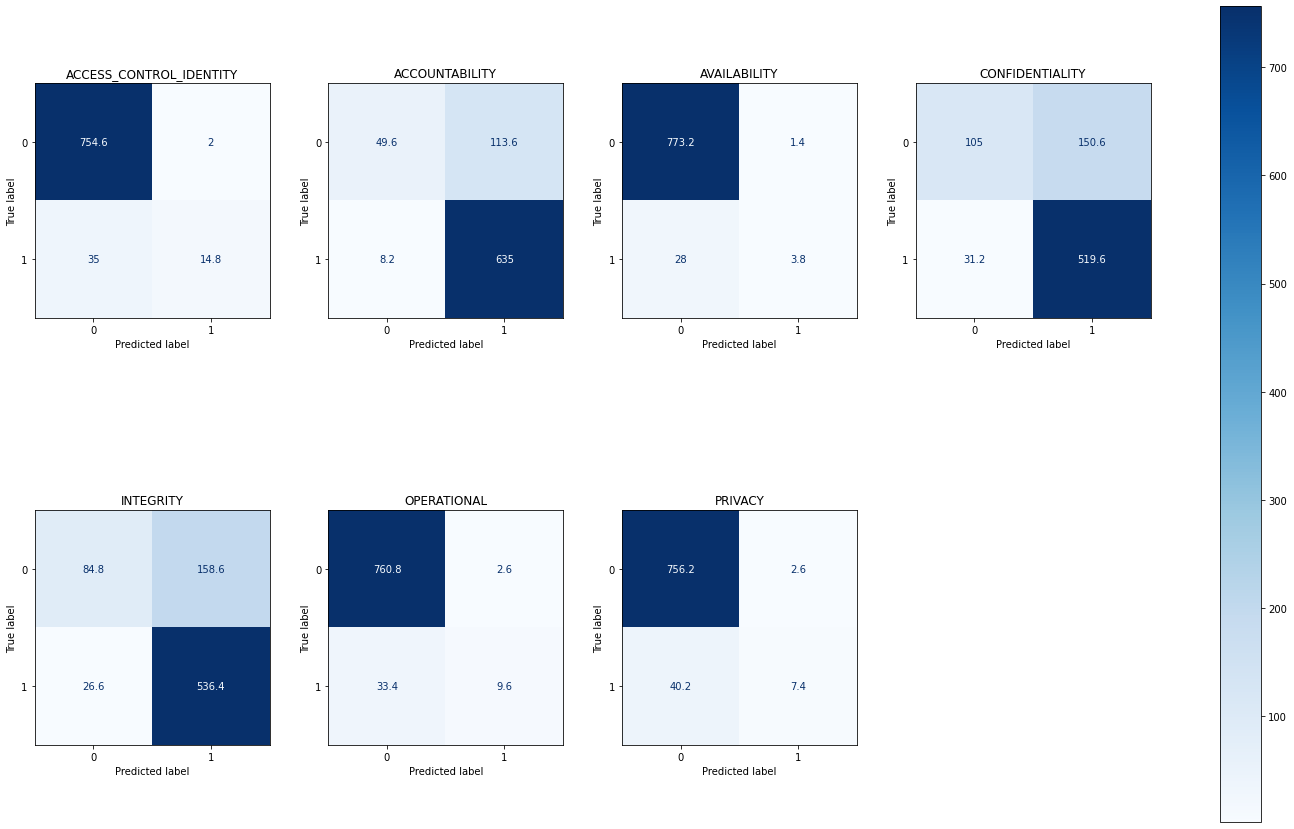

In [46]:
model = RandomForestClassifier(n_estimators=20, min_samples_split=10, min_samples_leaf=1, max_features='sqrt', max_depth=70, bootstrap=False)

ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, BinaryRelevance, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.1.2) LogisticRegression

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.7631585957446372
Precision: 0.8563609287831125
Recall Score: 0.8705232070448663
F1 Score: 0.8633323565408908
Hamming Loss: 0.09417596034696404


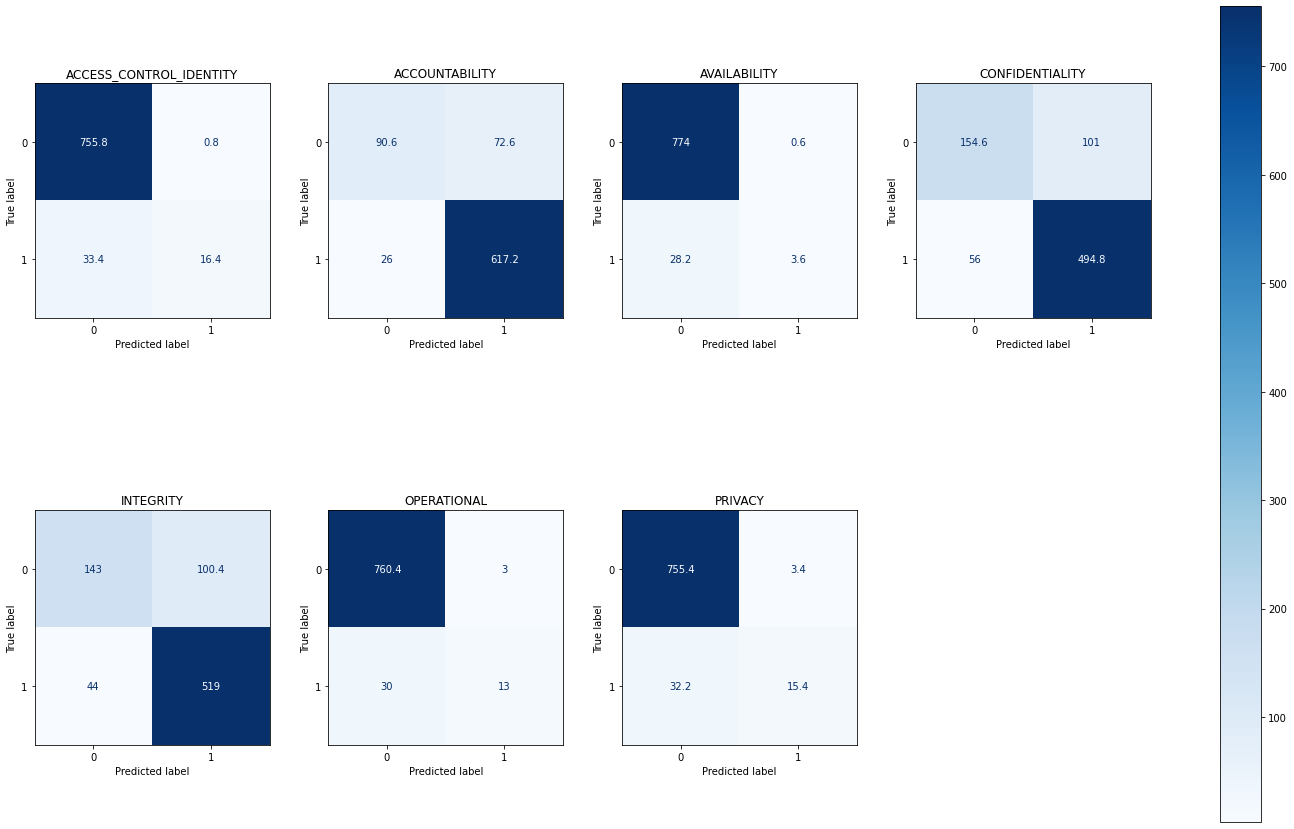

In [47]:
model = LogisticRegression(solver='newton-cg', penalty='l2', max_iter= 500, C=10)

ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, BinaryRelevance, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.1.3) Gaussian Naive Bayes

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.5418390227246206
Precision: 0.5386319862869419
Recall Score: 0.8236380461654267
F1 Score: 0.6513052065589129
Hamming Loss: 0.3014091955931505


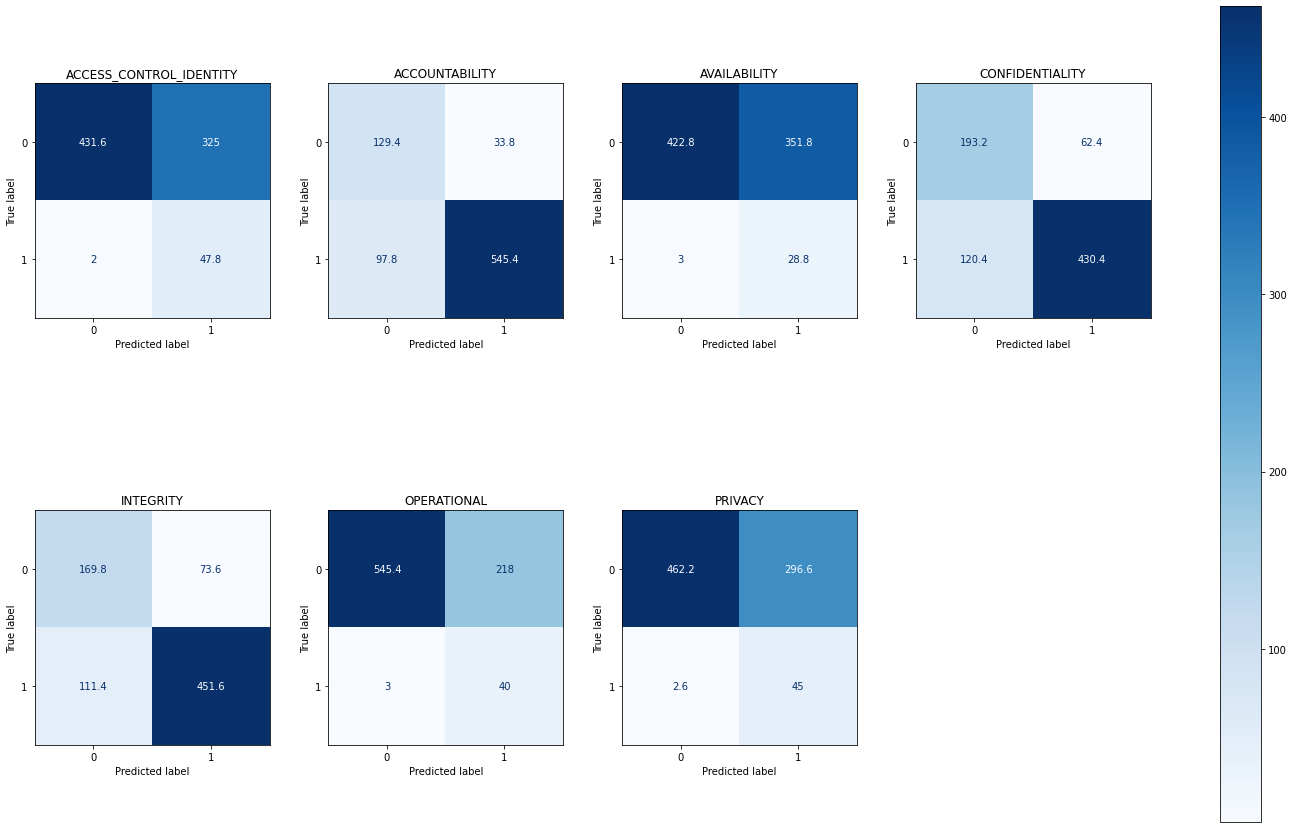

In [48]:
model = GaussianNB(var_smoothing=0.01)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, BinaryRelevance, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.1.4) k-NearestNeighbors

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.7402964240726562
Precision: 0.8166256432634794
Recall Score: 0.8448923826995107
F1 Score: 0.8305074697574757
Hamming Loss: 0.11783973711063289


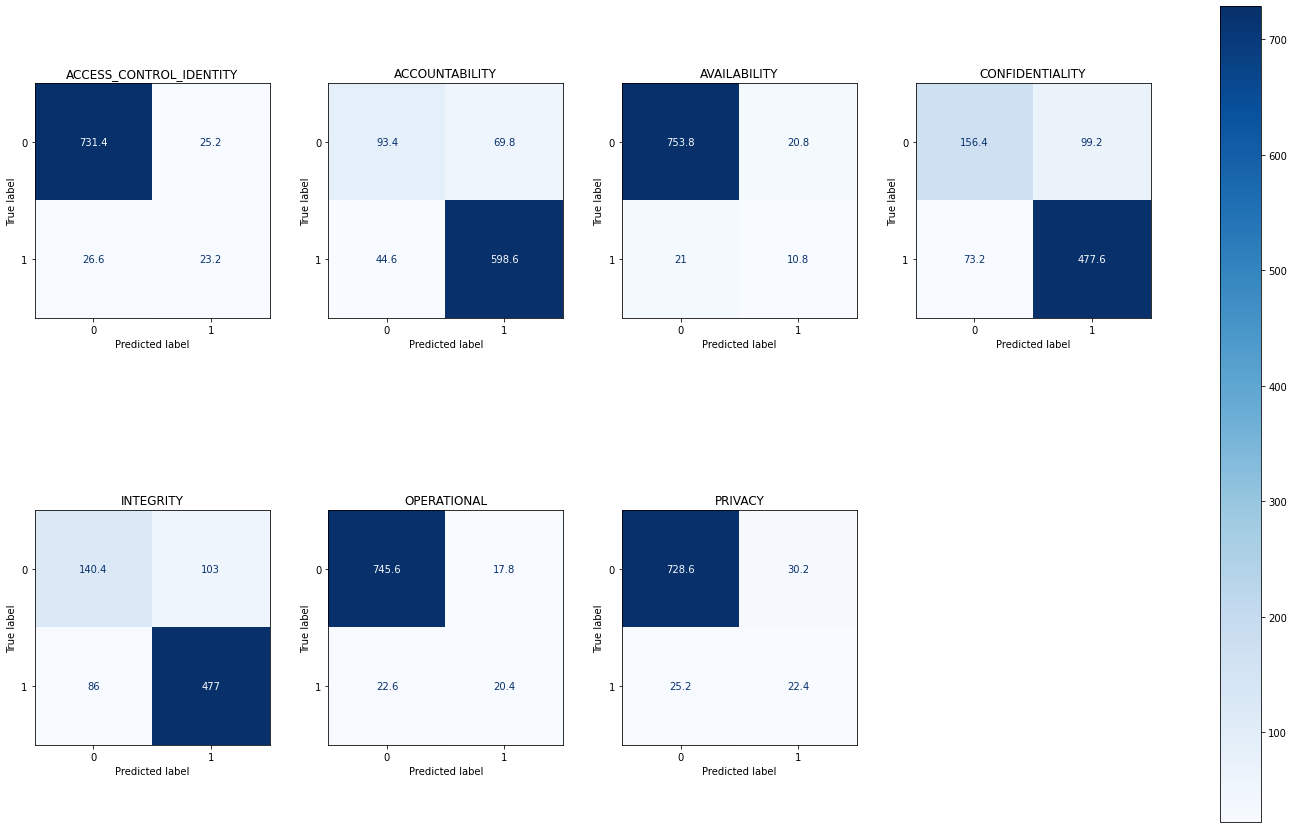

In [49]:
model = KNeighborsClassifier(algorithm='auto',weights='distance',p=2,n_neighbors=1, metric='minkowski', leaf_size=1)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, BinaryRelevance, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.1.5) Decision Tree

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.703720480329786
Precision: 0.7409242125931652
Recall Score: 0.8930313461837704
F1 Score: 0.8098250962133478
Hamming Loss: 0.14335232261842168


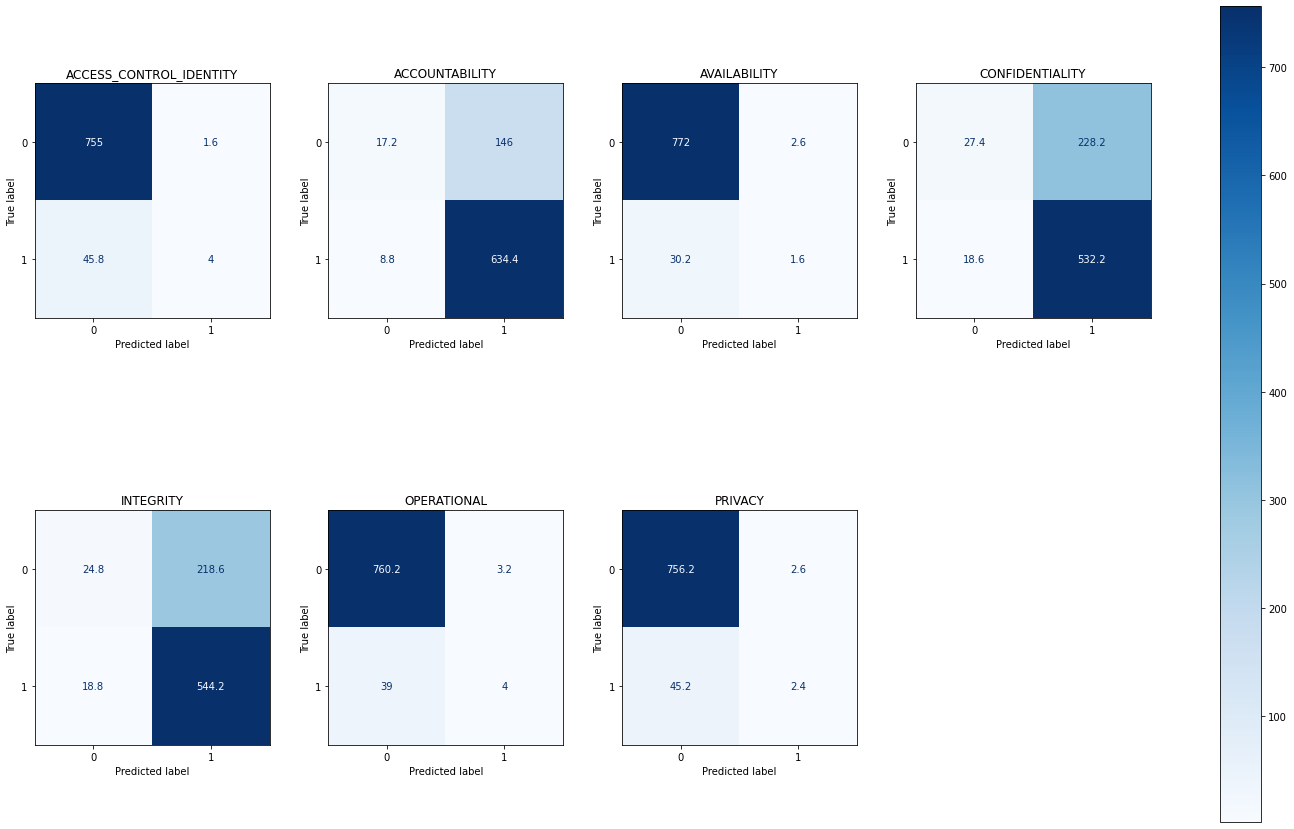

In [50]:
model = DecisionTreeClassifier(max_features='sqrt',max_depth=7,criterion='entropy',ccp_alpha=0.001)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, BinaryRelevance, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.1.6) Support Vector Machine

Training on fold 1/5...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Training on fold 2/5...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.7627122787273884
Precision: 0.8411002987974344
Recall Score: 0.8850356590407664
F1 Score: 0.8625026528184115
Hamming Loss: 0.09644307804758698


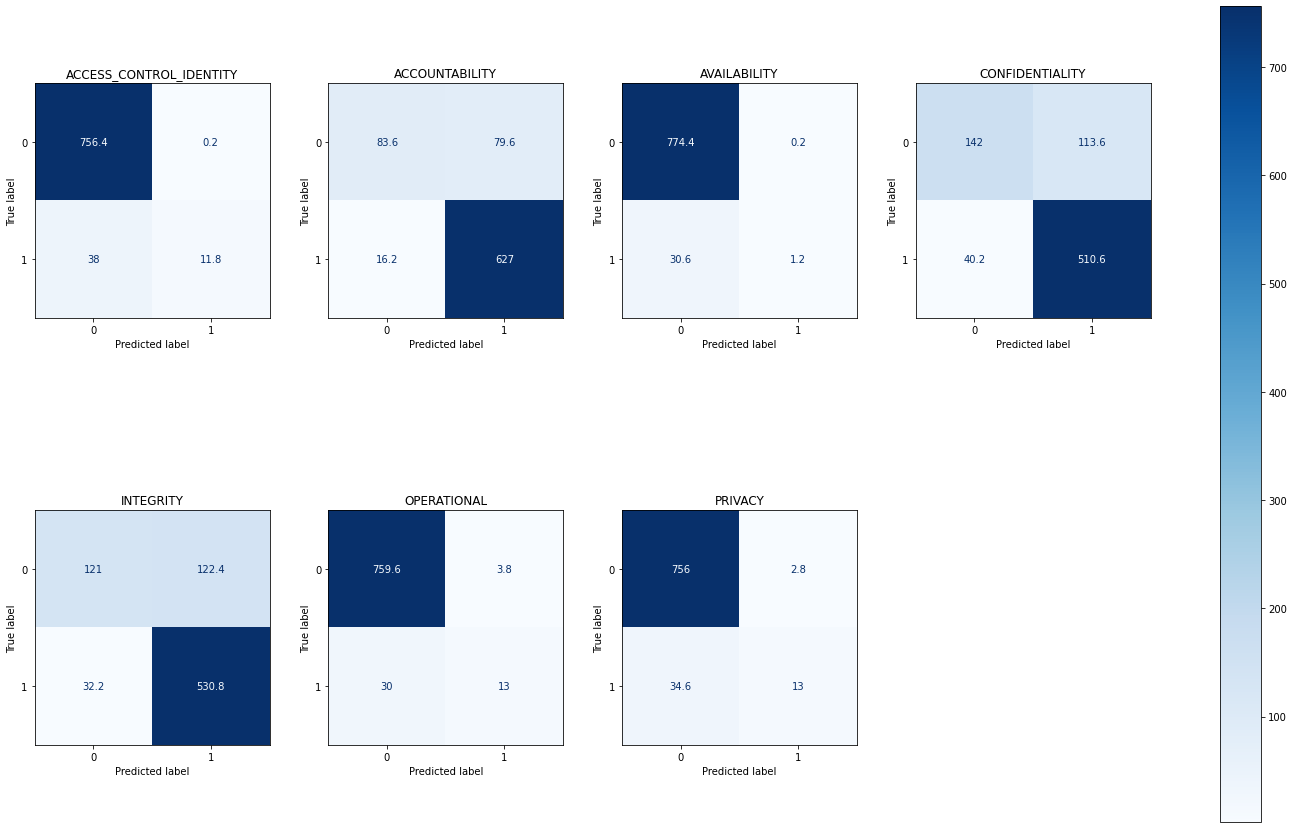

In [51]:
model = LinearSVC(penalty='l2', loss='hinge', fit_intercept=True, dual=True, C=1)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, BinaryRelevance, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

###**2.4.2) ClassifierChain**

####2.4.2.1) RandomForest

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.7527734166407868
Precision: 0.7991258861974693
Recall Score: 0.9003281131829735
F1 Score: 0.8466761809195095
Hamming Loss: 0.11143042511312087


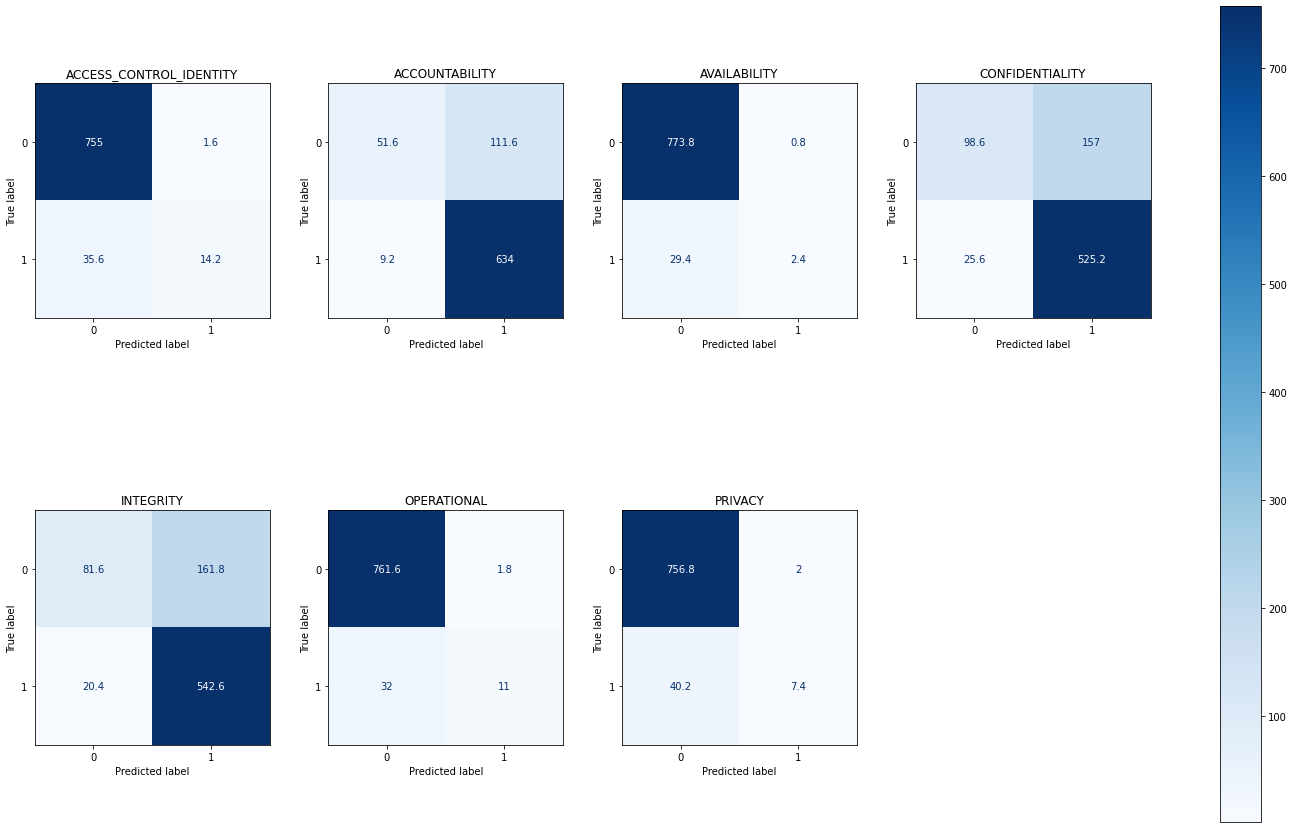

In [52]:
model = RandomForestClassifier(n_estimators=20, min_samples_split=10, min_samples_leaf=1, max_features='sqrt', max_depth=70, bootstrap=False)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, ClassifierChain, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.2.2) LogisticRegression

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.7705713550682971
Precision: 0.8414809477344782
Recall Score: 0.8833980431551985
F1 Score: 0.861918958594299
Hamming Loss: 0.09669104130070674


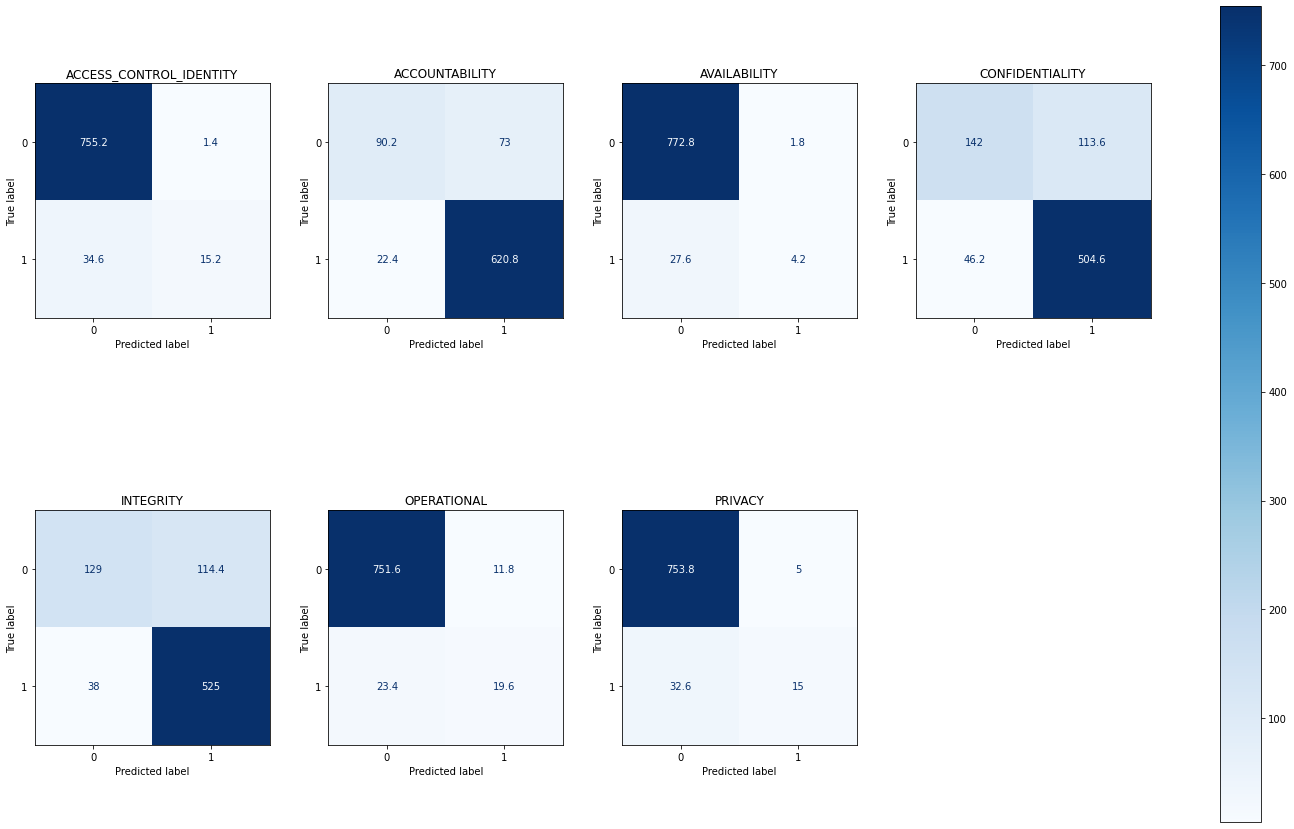

In [53]:
model = LogisticRegression(solver='newton-cg', penalty='l2', max_iter= 500, C=10)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, ClassifierChain, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.2.3) Gaussian Naive Bayes

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.5052450999986675
Precision: 0.5504104093183928
Recall Score: 0.7574452409655044
F1 Score: 0.637388373230161
Hamming Loss: 0.2945307959818093


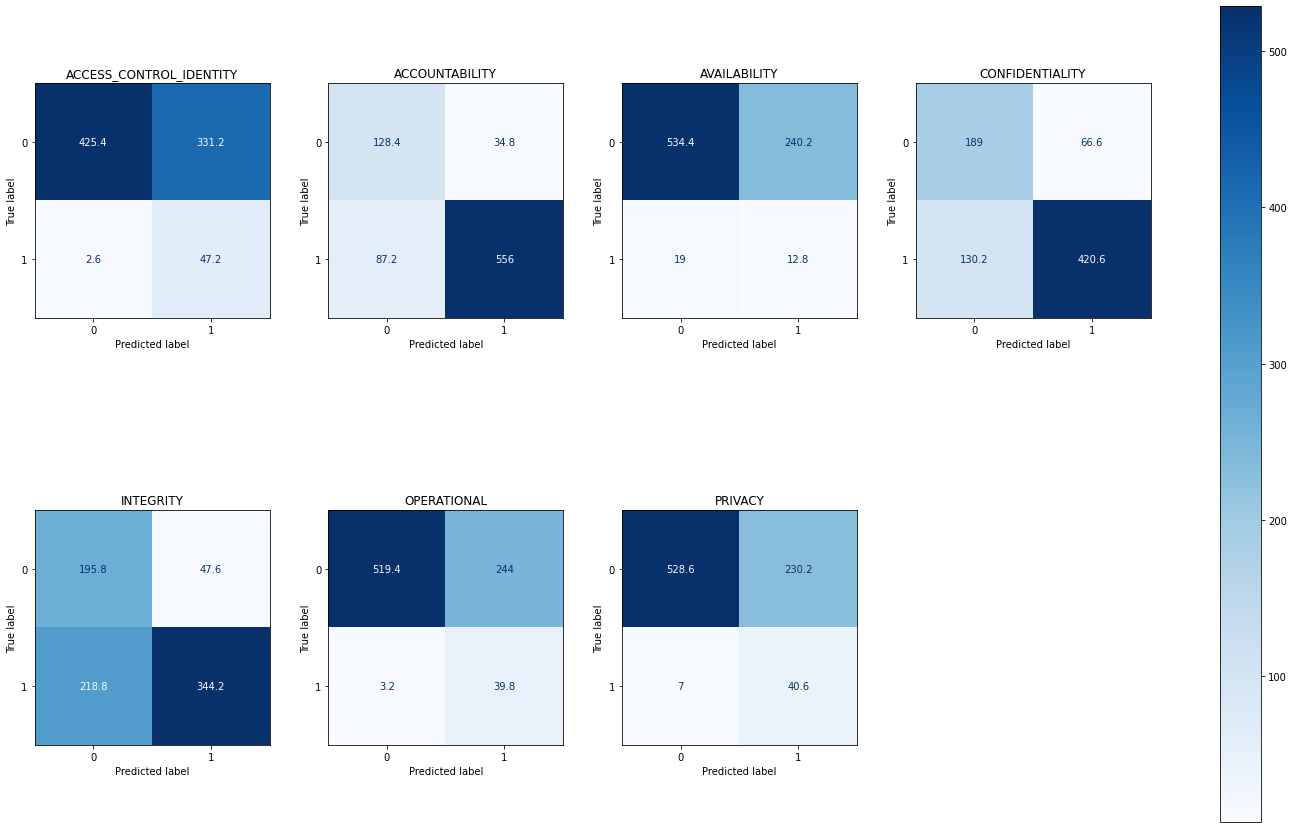

In [54]:
model = GaussianNB(var_smoothing=0.01)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, ClassifierChain, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.2.4) k-NearestNeighbors

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.7447062356571891
Precision: 0.8184645507993299
Recall Score: 0.8497562483888214
F1 Score: 0.8338120467923862
Hamming Loss: 0.11575192605292137


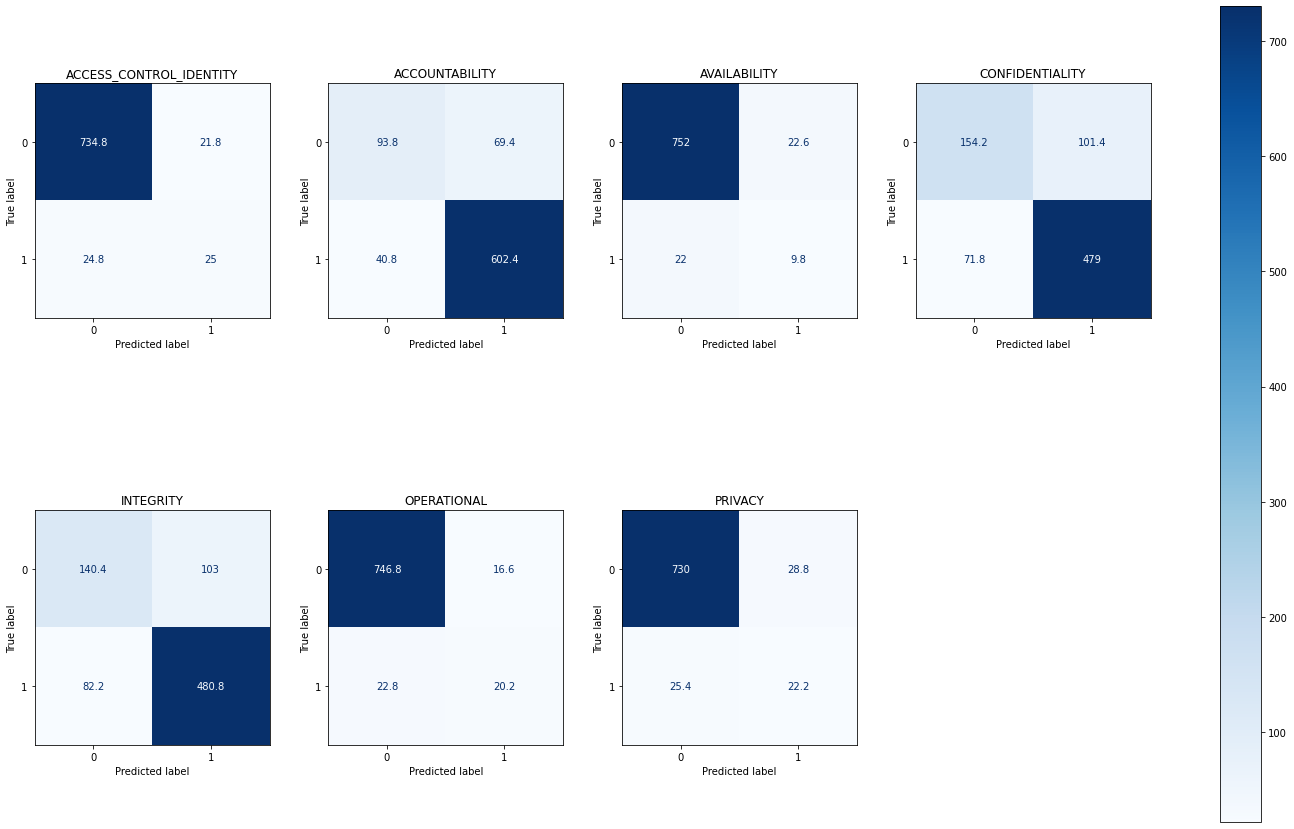

In [55]:
model = KNeighborsClassifier(algorithm='auto',weights='distance',p=2,n_neighbors=1, metric='minkowski', leaf_size=1)

ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, ClassifierChain, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.2.5) Decision Tree

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.7053064275267178
Precision: 0.7384203946305948
Recall Score: 0.8980456522112444
F1 Score: 0.8103970540828789
Hamming Loss: 0.14359773815344026


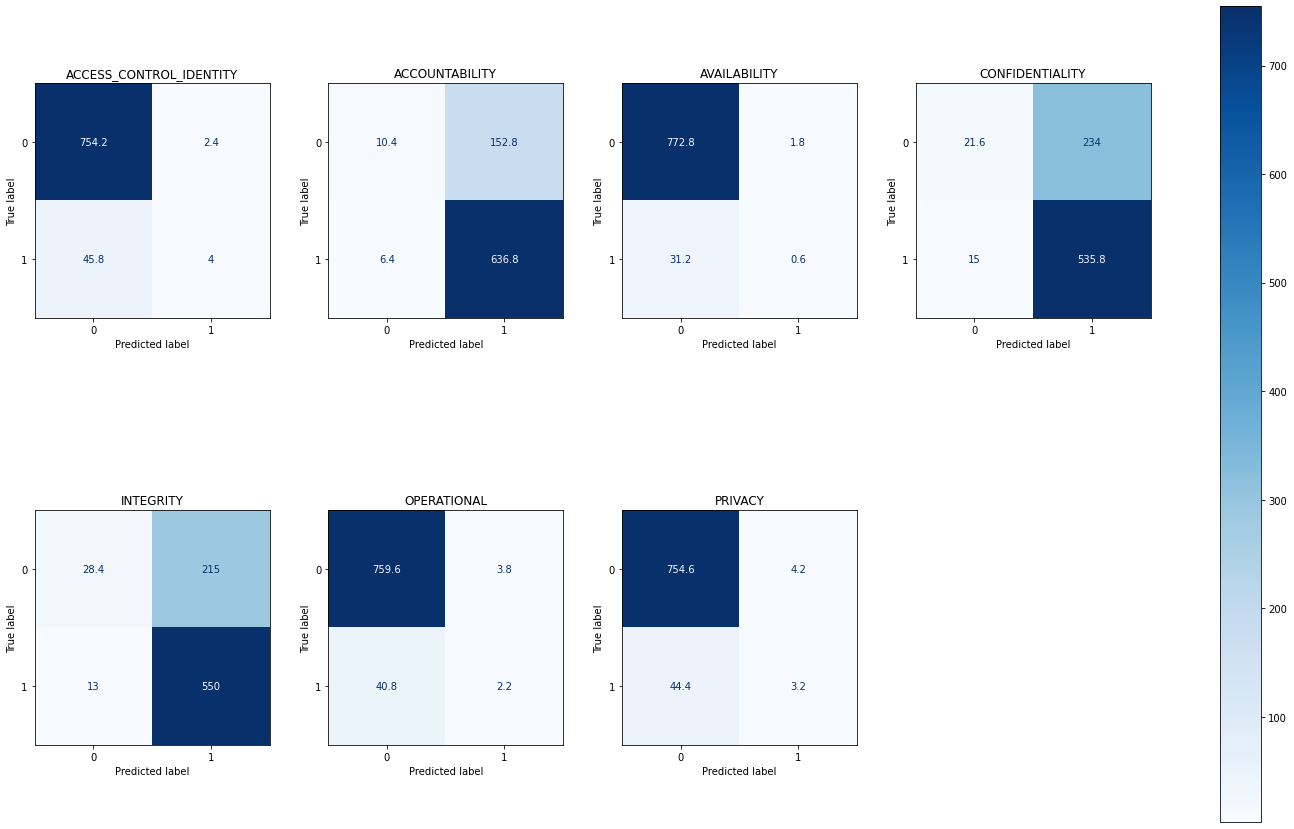

In [56]:
model = DecisionTreeClassifier(max_features='sqrt',max_depth=7,criterion='entropy',ccp_alpha=0.001)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, ClassifierChain, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.2.6) Support Vector Machine

Training on fold 1/5...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Training on fold 2/5...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.770536568466776
Precision: 0.824263825861086
Recall Score: 0.8984375453120339
F1 Score: 0.8597272594652017
Hamming Loss: 0.10019788741458006


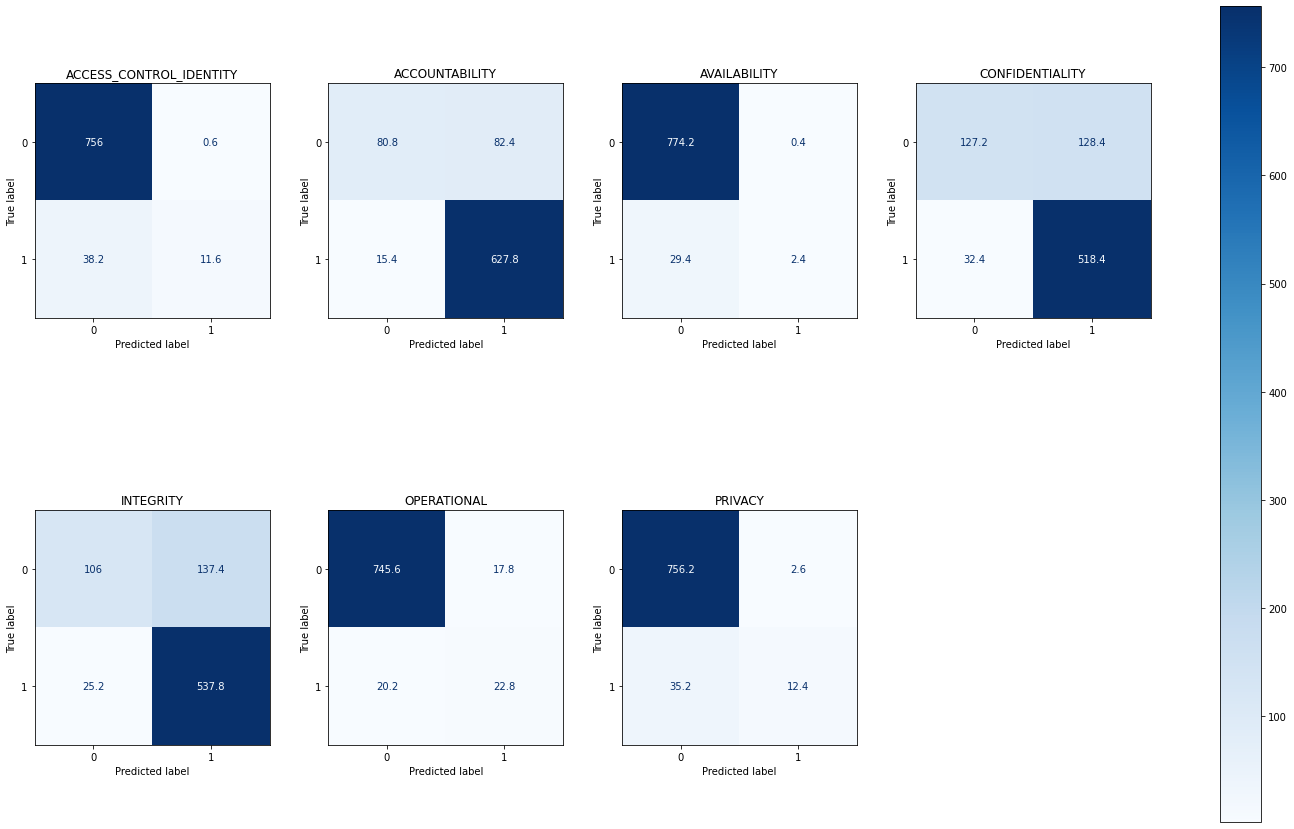

In [57]:
model = LinearSVC(penalty='l2', loss='hinge', fit_intercept=True, dual=True, C=1)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, ClassifierChain, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

###**2.4.3) LabelPowerset**

####2.4.3.1) RandomForest

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.7481079122606882
Precision: 0.777196369706717
Recall Score: 0.9032986045248752
F1 Score: 0.8354964872375904
Hamming Loss: 0.12156252429666507


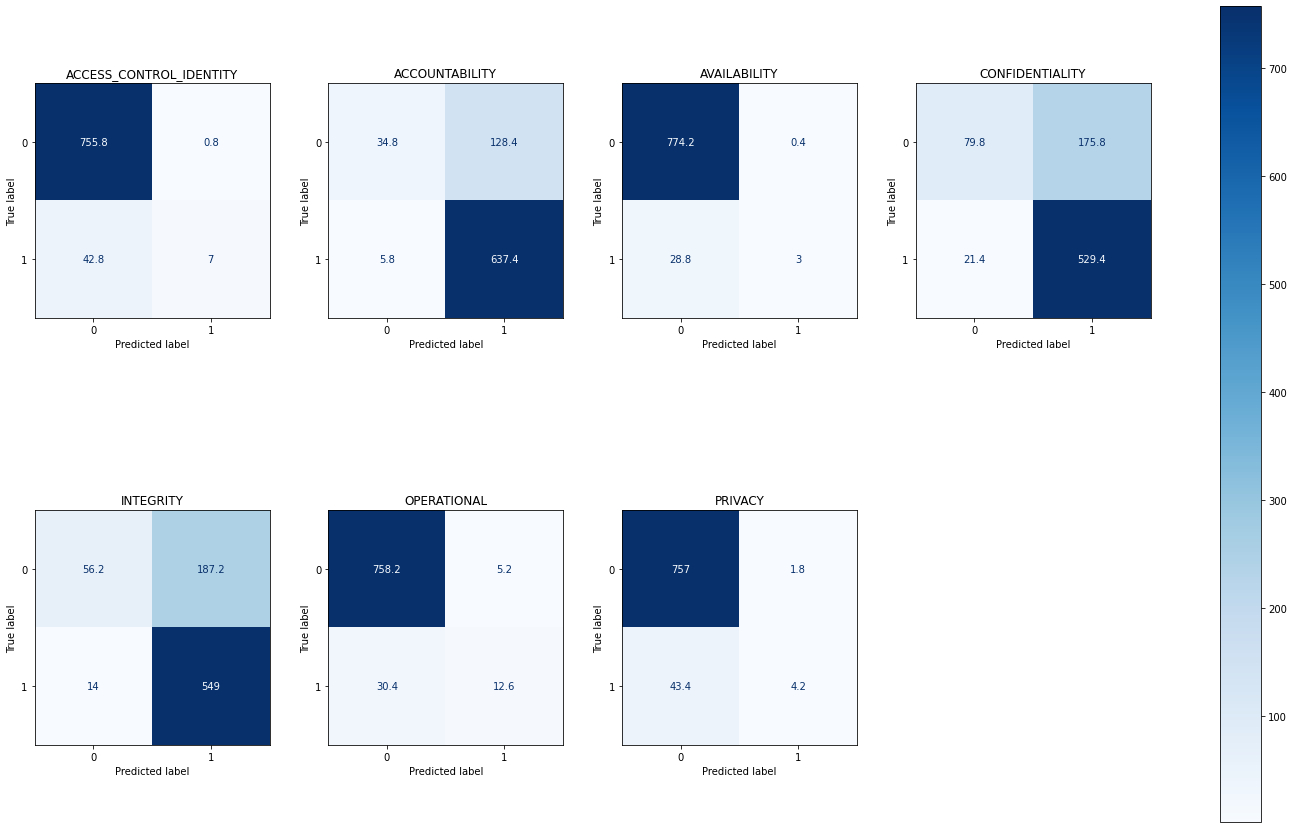

In [58]:
model = RandomForestClassifier(n_estimators=20, min_samples_split=10, min_samples_leaf=1, max_features='sqrt', max_depth=70, bootstrap=False)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, LabelPowerset, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.3.2) LogisticRegression

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.7789286618432799
Precision: 0.8362630133203318
Recall Score: 0.8862393340064632
F1 Score: 0.8604688667794115
Hamming Loss: 0.09817943578586341


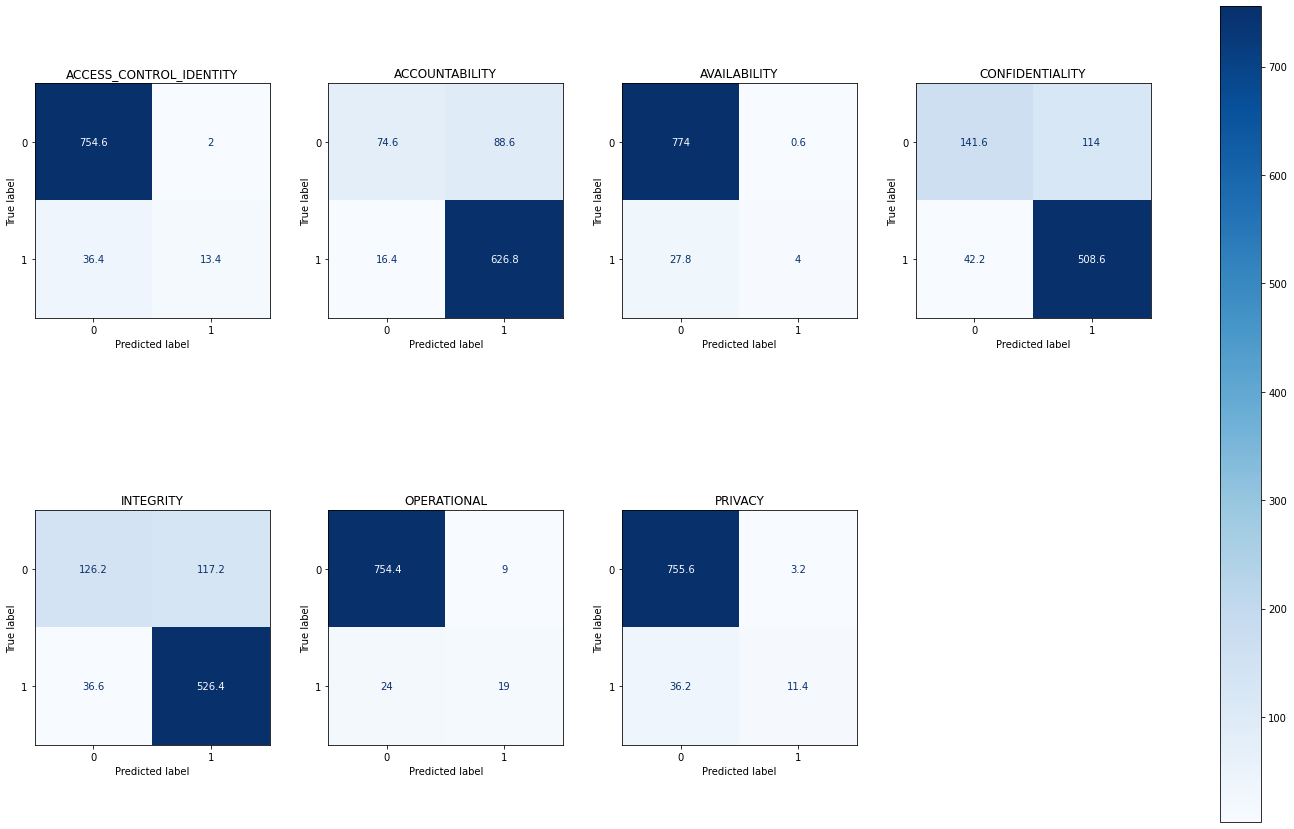

In [59]:
model = LogisticRegression(solver='newton-cg', penalty='l2', max_iter= 500, C=10)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, LabelPowerset, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.3.3) Gaussian Naive Bayes

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.5097371560232814
Precision: 0.552588194166339
Recall Score: 0.7628744632176103
F1 Score: 0.6408876878668373
Hamming Loss: 0.29223837680487164


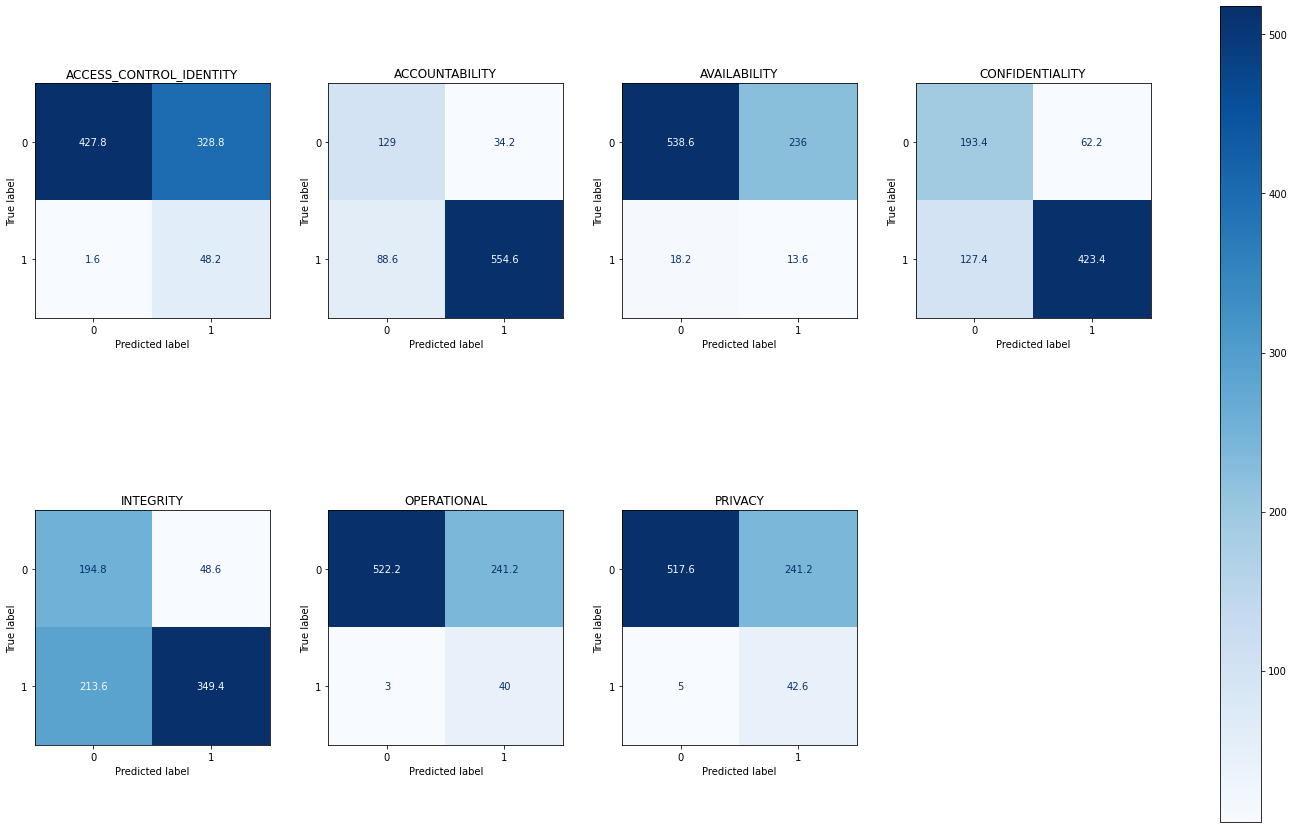

In [60]:
model = GaussianNB(var_smoothing=0.01)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, ClassifierChain, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.3.4) k-NearestNeighbors

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.7410462372766006
Precision: 0.8178856513650736
Recall Score: 0.8469884083625063
F1 Score: 0.8321374734342382
Hamming Loss: 0.11667560564310775


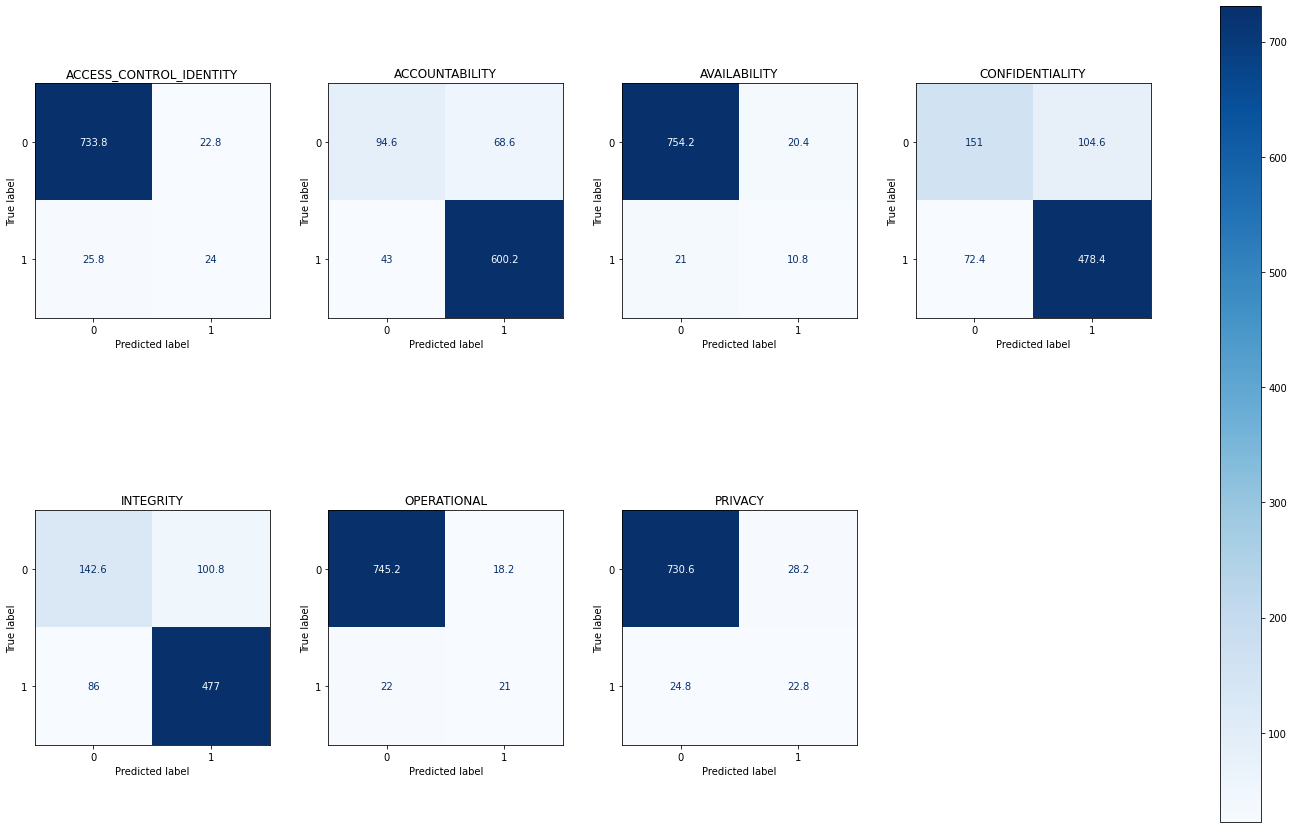

In [61]:
model = KNeighborsClassifier(algorithm='auto',weights='distance',p=2,n_neighbors=1, metric='minkowski', leaf_size=1)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, LabelPowerset, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.3.5) Decision Tree

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.6994706932619152
Precision: 0.7323393928693509
Recall Score: 0.8949263526283266
F1 Score: 0.8054696176711632
Hamming Loss: 0.14771138043712692


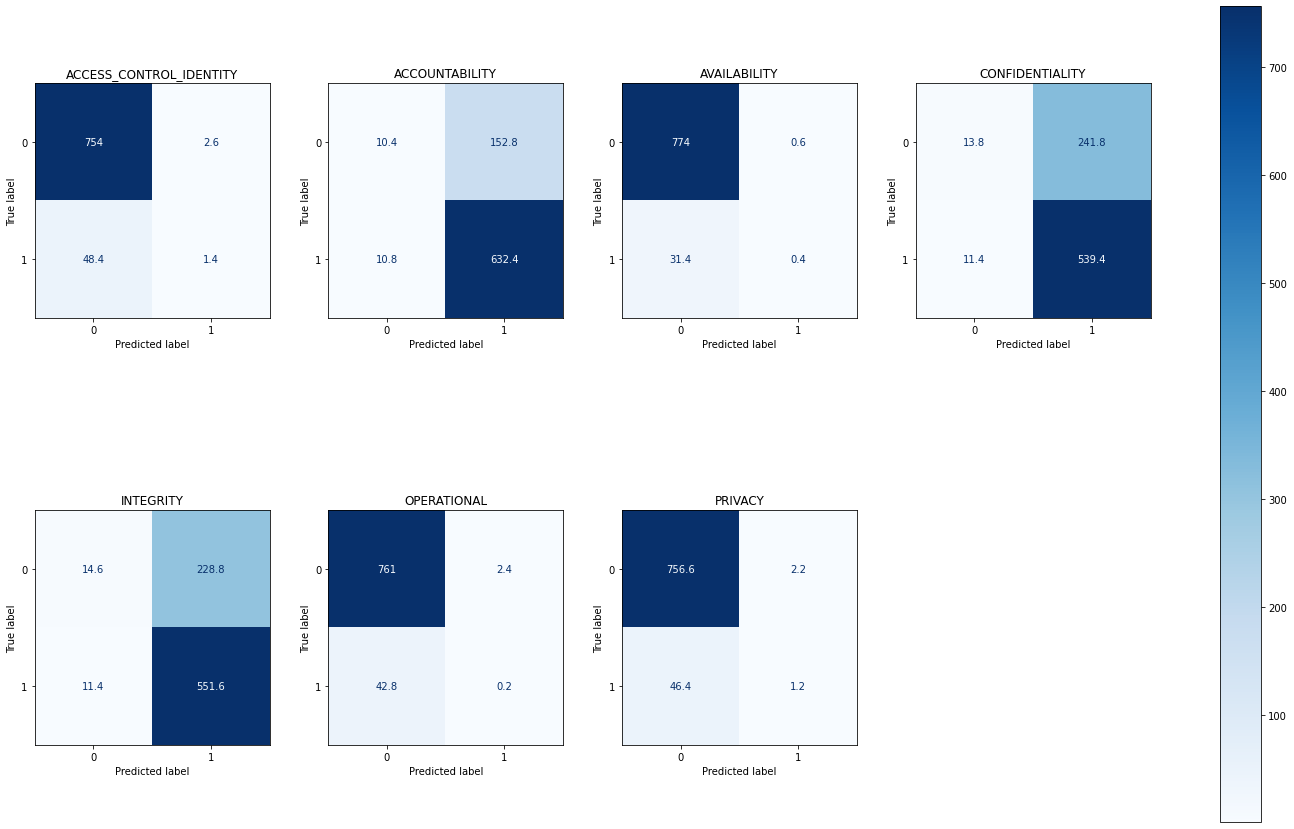

In [62]:
model = DecisionTreeClassifier(max_features='sqrt',max_depth=7,criterion='entropy',ccp_alpha=0.001)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, LabelPowerset, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.3.6) Support Vector Machine

Training on fold 1/5...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Training on fold 2/5...
Training on fold 3/5...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Training on fold 4/5...
Training on fold 5/5...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Hamming Score: 0.7731044633239141
Precision: 0.8266627057287078
Recall Score: 0.8890041437846177
F1 Score: 0.8566284816603911
Hamming Loss: 0.10168615012121426


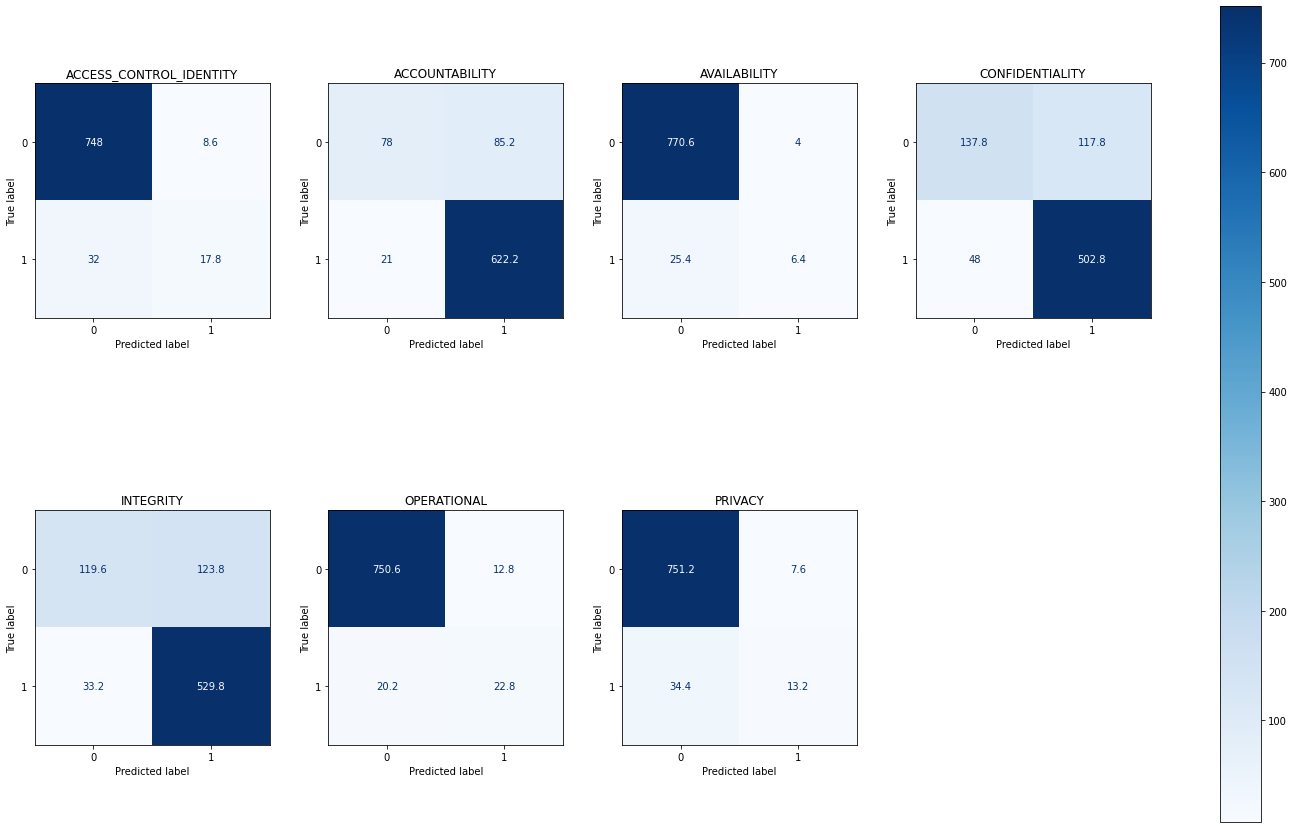

In [63]:
model = LinearSVC(penalty='l2', loss='hinge', fit_intercept=True, dual=True, C=1)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, LabelPowerset, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

##2.5) Risultati classifcatore multi-label

In [66]:
with pd.ExcelWriter('/content/drive/MyDrive/Security Extraction/results/results.xlsx', engine='openpyxl', mode='a',if_sheet_exists='replace') as writer:
    results.to_excel(writer, sheet_name='MultiLabelClf Tfidf')

results.head()

,BinaryRelevance LogisticRegression,BinaryRelevance RandomForestClassifier,BinaryRelevance GaussianNB,BinaryRelevance LinearSVC,BinaryRelevance KNeighborsClassifier,BinaryRelevance DecisionTreeClassifier,ClassifierChain LogisticRegression,ClassifierChain RandomForestClassifier,ClassifierChain GaussianNB,ClassifierChain LinearSVC,ClassifierChain KNeighborsClassifier,ClassifierChain DecisionTreeClassifier,LabelPowerset LogisticRegression,LabelPowerset RandomForestClassifier,LabelPowerset GaussianNB,LabelPowerset LinearSVC,LabelPowerset KNeighborsClassifier,LabelPowerset DecisionTreeClassifier
Hammer-Score-mean,0.763159,0.746942,0.541839,0.762712,0.740296,0.70372,0.770571,0.752773,0.509737,0.770537,0.744706,0.705306,0.778929,0.748108,NaN,0.773104,0.741046,0.699471
F1-mean,0.863332,0.844878,0.651305,0.862503,0.830507,0.809825,0.861919,0.846676,0.640888,0.859727,0.833812,0.810397,0.860469,0.835496,NaN,0.856628,0.832137,0.80547
Precision-mean,0.856361,0.800135,0.538632,0.8411,0.816626,0.740924,0.841481,0.799126,0.552588,0.824264,0.818465,0.73842,0.836263,0.777196,NaN,0.826663,0.817886,0.732339
Recall-mean,0.870523,0.894979,0.823638,0.885036,0.844892,0.893031,0.883398,0.900328,0.762874,0.898438,0.849756,0.898046,0.886239,0.903299,NaN,0.889004,0.846988,0.894926
Hammer-Loss-mean,0.094176,0.112313,0.301409,0.096443,0.11784,0.143352,0.096691,0.11143,0.292238,0.100198,0.115752,0.143598,0.098179,0.121563,NaN,0.101686,0.116676,0.147711


In [67]:
with pd.ExcelWriter('/content/drive/MyDrive/Security Extraction/results/predictions/tfidf/multilabel-clf.xlsx', engine='openpyxl', mode='w') as writer:
  df_pred1.to_excel(writer, sheet_name='Fold 1')
with pd.ExcelWriter('/content/drive/MyDrive/Security Extraction/results/predictions/tfidf/multilabel-clf.xlsx', engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
  df_pred2.to_excel(writer, sheet_name='Fold 2')
with pd.ExcelWriter('/content/drive/MyDrive/Security Extraction/results/predictions/tfidf/multilabel-clf.xlsx', engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
  df_pred3.to_excel(writer, sheet_name='Fold 3')
with pd.ExcelWriter('/content/drive/MyDrive/Security Extraction/results/predictions/tfidf/multilabel-clf.xlsx', engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
  df_pred4.to_excel(writer, sheet_name='Fold 4')
with pd.ExcelWriter('/content/drive/MyDrive/Security Extraction/results/predictions/tfidf/multilabel-clf.xlsx', engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
  df_pred5.to_excel(writer, sheet_name='Fold 5')
